# Выбор локации для скважины

**Описание проекта**. Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации**:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**:<br>
* Данные геологоразведки трёх регионов находятся в файлах: 
  * `/datasets/geo_data_0.csv`.
  * `/datasets/geo_data_1.csv`.
  * `/datasets/geo_data_2.csv`.
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи**:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

<a id="point0"></a>
# Оглавление
* [1 Загрузка и изучение данных](#Загрузка-и-изучение-данных)
  * [1.1 Загрузка данных](#Загрузка-данных)
  * [1.2 Изучение данных](#Изучение-данных)
* [2 Предобработка данных](#Предобработка-данных)
  * [2.1 Переименование столбцов](#Переименование-столбцов)
  * [2.2 Обработка пропусков](#Обработка-пропусков)
  * [2.3 Изменение типов данных](#Изменение-типов-данных)
  * [2.4 Обработка дубликатов](#Обработка-дубликатов)
    * [2.4.1 Обработка явных дубликатов](#Обработка-явных-дубликатов)
* [3 Исследовательский анализ данных](#Исследовательский-анализ-данных)
  * [3.1 Признак <code>f0</code>](#Признак-f0)
  * [3.2 Признак <code>f1</code>](#Признак-f1)
  * [3.3 Признак <code>f2</code>](#Признак-f2)
  * [3.4 Признак <code>product</code>](#Признак-product)
* [4 Корреляционный анализ](#Корреляционный-анализ)
* [5 Обучение моделей](#Обучение-моделей)
  * [5.1 Создание пайплайна](#Создание-пайплайна)
  * [5.2 Регион 0](#Регион-0)
    * [5.2.1 Поиск лучшей модели](#Поиск-лучшей-модели)
    * [5.2.2 Оценка качества модели на валидационных данных](#Оценка-качества-модели-на-валидационных-данных)
    * [5.2.3 Проверка модели на адекватность](#Проверка-модели-на-адекватность)
    * [5.2.4 Анализ результата](#Анализ-результата)
  * [5.3 Регион 1](#Регион-1)
    * [5.3.1 Поиск лучшей модели](#Поиск-лучшей-модели)
    * [5.3.2 Оценка качества модели на валидационных данных](#Оценка-качества-модели-на-валидационных-данных)
    * [5.3.3 Проверка модели на адекватность](#Проверка-модели-на-адекватность)
    * [5.3.4 Анализ результата](#Анализ-результата)
  * [5.4 Регион 2](#Регион-2)
    * [5.4.1 Поиск лучшей модели](#Поиск-лучшей-модели)
    * [5.4.2 Оценка качества модели на валидационных данных](#Оценка-качества-модели-на-валидационных-данных)
    * [5.4.3 Проверка модели на адекватность](#Проверка-модели-на-адекватность)
    * [5.4.4 Анализ результата](#Анализ-результата)
* [6 Расчет прибыли и рисков](#Расчет-прибыли-и-рисков)
  * [6.1 Определение достаточного объёма сырья для безубыточной разработки новой скважины](#Определение-достаточного-объёма-сырья-для-безубыточной-разработки-новой-скважины)
  * [6.2 Определение функции для расчета прибыли](#Определение-функции-для-расчета-прибыли)
  * [6.3 Расчет прибыли и рисков для каждого региона](#Расчет-прибыли-и-рисков-для-каждого-региона)
* [7 Общий вывод](#Общий-вывод)

## Загрузка и изучение данных
Импорт необходимых для выполнения проекта библиотек:

In [1]:
!pip install phik -q

In [2]:
import pandas as pd              # Импорт библиотеки pandas
import matplotlib.pyplot as plt  # Импорт библиотеки для работы с графиками
import numpy as np               # Импорт библиотеки NumPy
from scipy import stats                # Импорт статистических функций из библиотеки SciPy
from scipy.signal import argrelextrema # Импорт функций определения экстремумов из библиотеки SciPy

from phik import phik_matrix   # Импорт функции матрицы корреляции Фи
from phik.report import plot_correlation_matrix # Импорт функции отображения матрицы корреляции

from sklearn.model_selection import (train_test_split, # Импорт функции для разбивки датасета на выборки
                                     GridSearchCV)  # Импорт инструмента автоматизированного поиска гиперпараметров

from sklearn.compose import ColumnTransformer # Импорт инструмента подготовки данных
from sklearn.pipeline import Pipeline         # Импорт Pipeline

from sklearn.preprocessing import (StandardScaler, # Масштабирование: стандартизация
                                   MinMaxScaler)   # Масштабирование: нормализация

from sklearn.metrics import make_scorer, mean_squared_error # Импорт метрик

from sklearn.linear_model import LinearRegression # Импорт модели Линейной регрессии
from sklearn.dummy import DummyRegressor # Импорт Dummy-модели

Установка вспомогательных настроек, функций и констант:

In [3]:
# формат вывода float-чисел датафрейма:
pd.options.display.float_format = ("{:.2f}".format)

# настройка отображения графиков:
plt.rcParams["figure.figsize"] = (15,7) # размер графиков по умолчанию:
plt.rcParams.update({'axes.grid' : True, 'grid.alpha': 0.33, 'grid.linestyle': '--'}) # отображение сетки:

# установка цветовой палитры:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# переменные для форматирования шрифта при выводе информации:
green, red, bold, end = '\33[92m', '\33[91m', '\33[1m', '\33[0m'

# создание переменной псевдослучайности
RANDOM_STATE = 42

def dataset_info(df):
    """Функция для вывода общей информации о датасете"""
    print('• ' + '\33[4m' + 'Первые 10 строк датасета:' + end, f'[{df.dsc}]')
    display(df.head(10))
    print('• ' + '\33[4m' + 'Основная информация о датасете:' + end, f'[{df.dsc}]')
    df.info()

def is_that_snake(list_of_strings):
    """
    Данная функция получает на входе список со строковыми значениями (например, список заголовков датафрейма)
    и поочередно проверяет наличие НЕжелательных для оформления символов.
    Желательные символы: английский алфавит в нижнем регистре, нижнее подчеркивание и цифры от 0 до 9
    """
    snake_symbols, bad_list = list('abcdefghijklmnopqrstuvwxyz_0123456789'), []
    for i in list_of_strings:
        if set(i).issubset(snake_symbols): # проверка, что все элементы подмножества i
            pass                           # принадлежат множеству snake_symbols
        else: bad_list.append(i)
    return f'(!) Следует обратить внимание: {bad_list}' if bad_list else '✅ Проблем не обнаружено'

def stat_num(data_set, feature, rv=2, bins=50):
    """
    Функция отображения распределения числового признака.
    Для непрерывных величин строится диаграммы размаха и гистограммы распредления.
    Выводится описательная информация.
    """
    param = data_set[feature]
    dsr = param.describe()
    iqr = dsr['75%'] - dsr['25%']
    
    kde = stats.gaussian_kde(param)
    xx = np.linspace(dsr['min'], dsr['max'], bins)
    
    # конфигурация графиков:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    # диаграмма размаха:
    param.plot(kind='box', ax=axes[0])
    axes[0].set_title('Разброс значений признака')
    axes[0].set_ylabel(feature_dsc[feature])
    
    # гистограмма:
    bns =  plt.hist(param, bins=bins, orientation='horizontal')
    scale = max(bns[0]) / max(kde(xx))
    # масштабированная линия плотности:
    plt.plot(0.9 * scale * kde(xx), xx)
    axes[1].set_title('Гистограмма распределения')
    axes[1].set_xlabel('Частота')
    axes[1].axhline(dsr['mean'], color='r', linestyle='--', label='Среднее значение')
    axes[1].axhline(dsr['50%'], color='r', linestyle=':', label='Медиана')
    axes[1].legend()
    plt.show()
    
    # описательная информация:
    print(f"Описательная информация для признака '{feature}':")
    print(bold + "Минимальное значение:" + end, 
          round(dsr['min'], 2), bold + "\t|\tМаксимальное значение:" + end, round(dsr['max'], 2))
    print(bold + "Среднее значение:" + end, f"{round(dsr['mean'], rv)}")
    print(bold + "Медиана:" + end, round(dsr['50%'], 2))
    print(bold + "Межквартильный размах IQR:" + end, round(iqr, rv))
    print(bold + "Границы нормальных значений:" + end, 
          f"от {round(max([dsr['25%'] - 1.5*iqr, dsr['min']]), rv)} до",
          f"{round(min([dsr['75%'] + 1.5*iqr, dsr['max']]), rv)}")

def feature_density_spread(data_set, feature):
    """
    Функция для отрисовки распределения плотности значений признака 
    и отображения пиковых значений
    """
    data = data_set[feature].plot.kde(label=feature)
    x, y = data.lines[0]._x, data.lines[0]._y
    maxima = argrelextrema(y, np.greater)
    
    if data_set is geo_data_1 and feature == 'f0': 
        (lim_min, lim_max) = (-20, 20)
    elif data_set is geo_data_2 and feature == 'f0':
        (lim_min, lim_max) = (-5,5)
    elif data_set is geo_data_1 and feature == 'f1':
        (lim_min, lim_max) = (-10,10)
    elif data_set is geo_data_2 and feature == 'f1':
        (lim_min, lim_max) = (-2,2)        
    elif data_set is geo_data_0 and feature == 'f2':
        (lim_min, lim_max) = (-5,10)
    elif data_set is geo_data_2 and feature == 'f2':
        (lim_min, lim_max) = (-5,10)    
    else:
        (lim_min, lim_max) = (data_set[feature].min(), data_set[feature].max())

    peak_list = [x[i] for i in tuple(maxima[0]) if lim_min <= x[i] <= lim_max]    
    
    for i in peak_list:
        plt.axvline(i, color='r', linestyle='dashed', label=f"f0={i:.2f}")
        
    plt.title(f"Распределение плотности значений признака '{feature}' для датасета {data_set.dsc}")
    plt.xlabel(feature_dsc[feature])
    plt.ylabel("Плотность значений")
    plt.xlim(data_set[feature].min(),data_set[feature].max())
    plt.legend()
    plt.show()
    
    print(f"Пиковые значения: {peak_list}")

def correlation_matrix_heatmap(data_overview, coef):
    """
    Отрисовка тепловой карты для матрицы корреляции
    """
    coef_type = {'pearson':'коэффициет Пирсона', 'phi':'коэффициет $\phi_K$'}
    
    plot_correlation_matrix(
        data_overview.values,
        x_labels=data_overview.columns,
        y_labels=data_overview.index,
        vmin=0, vmax=1, color_map='Oranges',
        title=f"Тепловая карта матрицы корреляции ({coef_type[coef]})\nдля датасета '{df.dsc}'",
        fontsize_factor=1.3,
        figsize=(11, 10)
    )
    plt.grid(visible=False)
    plt.show()

def target_compare(y_true, y_pred):
    """
    Функция для отрисовки распределения плотности значений y_true, y_pred
    """
    pd.Series(y_true).plot.kde(label='y_true')
    pd.Series(y_pred).plot.kde(label='y_pred')
    plt.title("Распределение плотности значений целевого признака датасета")
    plt.xlabel(feature_dsc['product'])
    plt.ylabel("Плотность значений")
    plt.xlim(y_true.min(),y_true.max())
    plt.legend()
    plt.show()

def show_best_5(data):
    """
    Показывает 5 лучших по метрике моделей среди результатов GridSearchCV
    """
    result_reg = pd.DataFrame(data.cv_results_).sort_values('rank_test_score')[
    ['rank_test_score', 'param_models', 'mean_test_score','mean_fit_time','params']
    ]
    result_reg['mean_test_score'] = -result_reg['mean_test_score']
    result_reg['param_models'] = result_reg['param_models'].astype('str').str.replace('\(.*','', regex=True)
    display(result_reg.head(5).style.format({'mean_test_score': '{:.4f}'}))

def threshold_rate_compare(y1, y2, y3):
    """
    Функция для сравнения относительного распределения значений превышающих порог
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    plt.suptitle("Относительное распределение значений целевого признака, " + \
                 f"\nпревышающих минимальный порог безубыточной добычи [{min_product_unit:.1f}]" + \
                 ' для рассматриваемых регионов')
    
    labels = ['Не превышает','Превышает']
    (pd.Series(y1) > min_product_unit).value_counts().plot(kind='pie',ax=axes[0],autopct='%1.1f%%',labels=labels)
    (pd.Series(y2) > min_product_unit).value_counts().plot(kind='pie',ax=axes[1],autopct='%1.1f%%',labels=labels)
    (pd.Series(y3) > min_product_unit).value_counts().plot(kind='pie',ax=axes[2],autopct='%1.1f%%',labels=labels)
    
    axes[0].set_title('Регион 0')
    axes[1].set_title('Регион 1')
    axes[2].set_title('Регион 2')
    axes[0].yaxis.set_visible(False)
    axes[1].yaxis.set_visible(False)
    axes[2].yaxis.set_visible(False)
    plt.show()

[Вернуться к оглавлению](#point0)

### Загрузка данных
Загрузим данные в датафреймы:

In [4]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Изучение данных
Для удобства и наглядности информации зададим имеющимся датасетам свойства с именами:

In [5]:
geo_data_0.dsc = 'geo_data_0'
geo_data_1.dsc = 'geo_data_1'
geo_data_2.dsc = 'geo_data_2'

Выведем общую информацию об имеющихся датасетах:

In [6]:
for d in [geo_data_0, geo_data_1, geo_data_2]:
    dataset_info(d)
    print('\n* * *\n')

• Первые 10 строк датасета: [geo_data_0]


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04
5,wX4Hy,0.97,0.49,-0.74,64.74
6,tL6pL,0.65,0.53,1.78,49.06
7,BYPU6,-0.40,0.81,-5.62,72.94
8,j9Oui,0.64,-0.55,2.37,113.36
9,OLuZU,2.17,0.56,9.44,127.91


• Основная информация о датасете: [geo_data_0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

* * *

• Первые 10 строк датасета: [geo_data_1]


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77
5,HHckp,-3.33,-2.21,3.00,84.04
6,h5Ujo,-11.14,-10.13,4.00,110.99
7,muH9x,4.23,-0.00,2.00,53.91
8,YiRkx,13.36,-0.33,5.00,134.77
9,jG6Gi,1.07,-11.03,5.00,137.95


• Основная информация о датасете: [geo_data_1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

* * *

• Первые 10 строк датасета: [geo_data_2]


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60
5,LzZXx,-0.76,0.71,2.59,90.22
6,WBHRv,-0.57,0.32,1.77,45.64
7,XO8fn,-1.91,-2.46,-0.18,72.48
8,ybmQ5,1.78,-0.28,3.00,106.62
9,OilcN,-1.21,-0.44,5.92,52.95


• Основная информация о датасете: [geo_data_2]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

* * *



**Выводы**:
* Датасет `geo_data_0`:
  * Состоит из 100000 строк и 5 столбцов:
    * `id` — уникальный идентификатор скважины;
    * `f0`, `f1`, `f2` — три признака точек;
    * `product` — объём запасов в скважине (тыс. баррелей).
  * Наименования столбцов соответствуют описанию.
  * Не содержит пропусков.
* Датасет `geo_data_1`:
  * Состоит из 100000 строк и 5 столбцов: `id`, `f0`, `f1`, `f2`, `product`.
  * Наименования столбцов соответствуют описанию и совпадают с предыдущим датасетом.
  * Не содержит пропусков.
* Датасет `geo_data_2`:
  * Состоит из 100000 строк и 5 столбцов: `id`, `f0`, `f1`, `f2`, `product`.
  * Наименования столбцов соответствуют описанию и совпадают с предыдущим датасетом.
  * Не содержит пропусков.
* Имеющиеся данные соответствуют описанию и структуре, заявленным заказчиком.
* Значения ячеек выглядят реалистично.
* Значения ячеек выглядят уникально.

[Вернуться к оглавлению](#point0)

## Предобработка данных
### Переименование столбцов
Отобразим заголовки столбцов для наших данных:

In [7]:
print("Заголовки датасета:")
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print('•', bold + df.dsc + end, df.columns.to_list())

Заголовки датасета:
• geo_data_0 ['id', 'f0', 'f1', 'f2', 'product']
• geo_data_1 ['id', 'f0', 'f1', 'f2', 'product']
• geo_data_2 ['id', 'f0', 'f1', 'f2', 'product']


Заголовки датафреймов выглядят соответствующими стандарту. 

Используя вспомогательную функцию, можно убедиться, что в заголовках действительно отсутствуют нежелательные символы:

In [8]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(bold + df.dsc + end + ':', is_that_snake(df.columns))

geo_data_0: ✅ Проблем не обнаружено
geo_data_1: ✅ Проблем не обнаружено
geo_data_2: ✅ Проблем не обнаружено


**Вывод**: убедились, что заголовки датасетов соответствуют стандарту оформления данных.

[Вернуться к оглавлению](#point0)

### Обработка пропусков
На этапе первичного ознакомления с данными пропусков замечено не было. Убедимся в этом еще раз:

In [9]:
for d in [geo_data_0, geo_data_1, geo_data_2]:
    print(f'- Количество пропусков в датасете {d.dsc}: {d.isna().sum().sum()}') 

- Количество пропусков в датасете geo_data_0: 0
- Количество пропусков в датасете geo_data_1: 0
- Количество пропусков в датасете geo_data_2: 0


**Вывод**: убедились, что в имеющихся датасетах действительно отсутствуют пропуски.

[Вернуться к оглавлению](#point0)

### Изменение типов данных
Для имеющихся датасетов отобразим 1 произвольную строку с данными, а также строку с указанием типов данных:

In [10]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    display(pd.concat([df.sample(), 
    pd.DataFrame(df.dtypes, columns=['dtypes']).transpose()]).style.set_caption(f"Датасет '{df.dsc}':"))

,id,f0,f1,f2,product
87031,rqxy1,-0.645191,0.814834,6.723704,151.486788
dtypes,object,float64,float64,float64,float64


,id,f0,f1,f2,product
92523,OJOM9,-7.122688,-1.383851,2.002650,57.085625
dtypes,object,float64,float64,float64,float64


,id,f0,f1,f2,product
46360,XbZJJ,1.003385,1.116018,-1.436413,24.840378
dtypes,object,float64,float64,float64,float64


**Вывод**: 
* набор обучающих признаков и целевой признак - это числовые непрерывные величины (`float`)
* типы данных признаков не требуют изменений.

[Вернуться к оглавлению](#point0)

### Обработка дубликатов
Набор обучающих признаков и целевой признак - это числовые непрерывные величины, поэтому искать среди них неявные дубликаты нет необходимости - уникальность значений определяется уникальностью признака `id` - (уникальный идентификатор скважины).
#### Обработка явных дубликатов
Проверим, есть ли явные дубликаты в данных:

In [11]:
print('Количество дублирующихся строк:')
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f'- {df.dsc}: {df.duplicated().sum()}')

Количество дублирующихся строк:
- geo_data_0: 0
- geo_data_1: 0
- geo_data_2: 0


Полные дубликаты строк в имеющихся данных отсутствуют.

Также проверим - есть ли дубликаты среди значений `id`:

In [12]:
print('Количество дубликатов в колонке id:')
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f"- {df.dsc}: {df.duplicated(subset=['id']).sum()}")

Количество дубликатов в колонке id:
- geo_data_0: 10
- geo_data_1: 4
- geo_data_2: 4


В датасетах имеются дубликаты среди `id`. Отобразим такие строки:

In [13]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    index_list = df[df.duplicated(subset=['id'])]['id'].to_list()
    display(df.query('id in @index_list').sort_values(by='id').style.set_caption(f"Датасет '{df.dsc}':"))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Видно, что для некоторых скважин с уникальным `id` пристуствует 2 строки с различными значениями признаков. 

По условию задания никак не обозначено, может ли скважина иметь более одной записи в датасете и как поступить в таком случае для устранения дубликата. Поэтому оставим данные без изменений.

Проверим, есть ли одинковые значения `id` среди разных датасетов:

In [14]:
print(f"Число дублей id между 'geo_data_0' и 'geo_data_1': {len(set(geo_data_0['id']) & set(geo_data_1['id']))}")
print(f"Число дублей id между 'geo_data_0' и 'geo_data_2': {len(set(geo_data_0['id']) & set(geo_data_2['id']))}")
print(f"Число дублей id между 'geo_data_1' и 'geo_data_1': {len(set(geo_data_1['id']) & set(geo_data_2['id']))}")

Число дублей id между 'geo_data_0' и 'geo_data_1': 10
Число дублей id между 'geo_data_0' и 'geo_data_2': 17
Число дублей id между 'geo_data_1' и 'geo_data_1': 4


Среди разных датасетов присутсвуют одинаковые значения среди `id`, что представляет противоречие:
* если дубликаты `id` среди разных датасетов действительно принадлежат одной и той же скважине, то это странно, потому что возникает вопрос - как одна и та же скважина может находиться в двух разных регионах;
* поскольку имеющиеся датасеты, в контексте задачи, рассматриваются раздельно, то одинаковый `id` может быть результатом того, что названия выбирались для каждого датасета отдельно без учета присутсвует ли уже данный `id` в других датасетах.

**Выводы**:
* Полные дубликаты строк в имеющихся данных отсутствуют.
* Однако, внутри отдельных датасетов имеются дубли среди значений `id`:
  * geo_data_0: 10 дублей
  * geo_data_1: 4 дублей
  * geo_data_2: 4 дублей
* Поскольку, по условию задания никак не обозначено, может ли скважина иметь более одной записи в датасете и как поступить в таком случае для устранения дубликата - данные были оставлены без изменений.
* Также было выявлено, что различные датасеты имеют одинаковые значения `id`.
  * С одной стороны это вызывает противоречие - одна и та же скважина не может находиться в разных регионах.
  * С другой стороны - это можно объяснить алгоритмом присвоения названий - названия внутри одного региона могли выдаваться без учета проверки уникальности `id` в других регионах. Данные были оставлены без изменений.

[Вернуться к оглавлению](#point0)

## Исследовательский анализ данных
Для более наглядного представления полученных результатов я сформирую словарь с описанием признаков.

In [15]:
feature_dsc = {
    'f0':'Признак скважины f0', 
    'f1':'Признак скважины f1', 
    'f2':'Признак скважины f2',
    'product': 'Объём запасов нефти в скважине (тыс. баррелей)'
}

### Признак `f0`
Отобразим распределение признака `f0` для рассматриваемых датасетов:

Распределение признака для датасета 'geo_data_0':


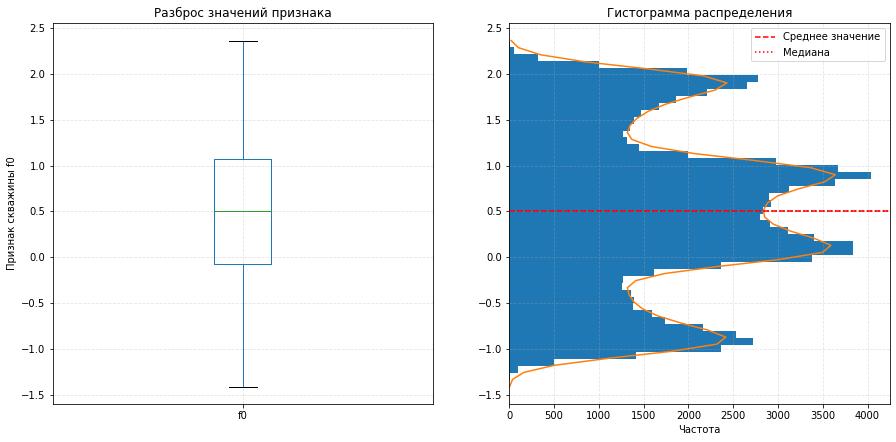

Описательная информация для признака 'f0':
Минимальное значение: -1.41 	|	Максимальное значение: 2.36
Среднее значение: 0.5
Медиана: 0.5
Межквартильный размах IQR: 1.15
Границы нормальных значений: от -1.41 до 2.36

Рассмотрим более подробно распределение значений:


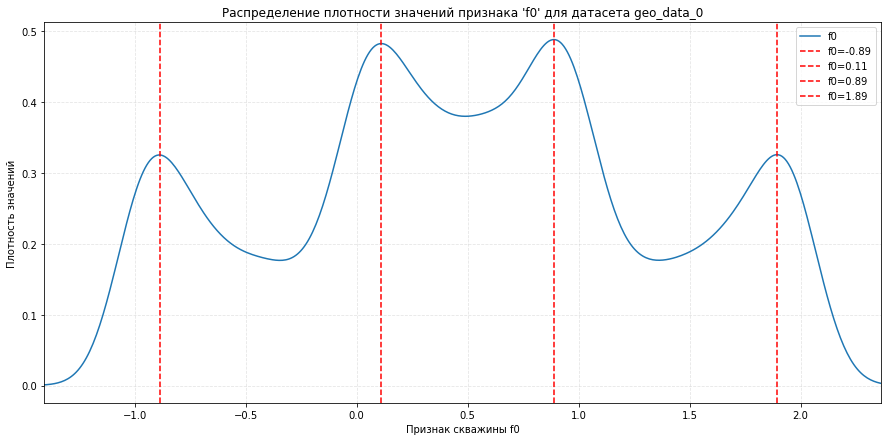

Пиковые значения: [-0.8858078563893099, 0.11071580212584742, 0.8883062326338864, 1.8923793128044624]

Распределение признака для датасета 'geo_data_1':


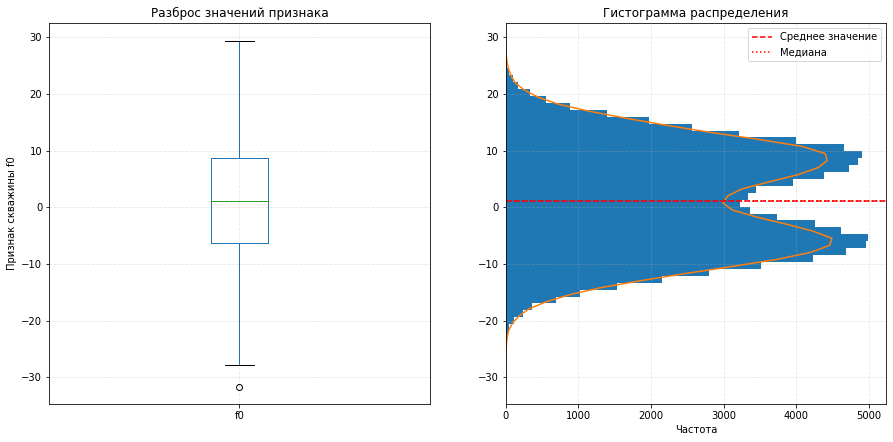

Описательная информация для признака 'f0':
Минимальное значение: -31.61 	|	Максимальное значение: 29.42
Среднее значение: 1.14
Медиана: 1.15
Межквартильный размах IQR: 14.92
Границы нормальных значений: от -28.68 до 29.42

Рассмотрим более подробно распределение значений:


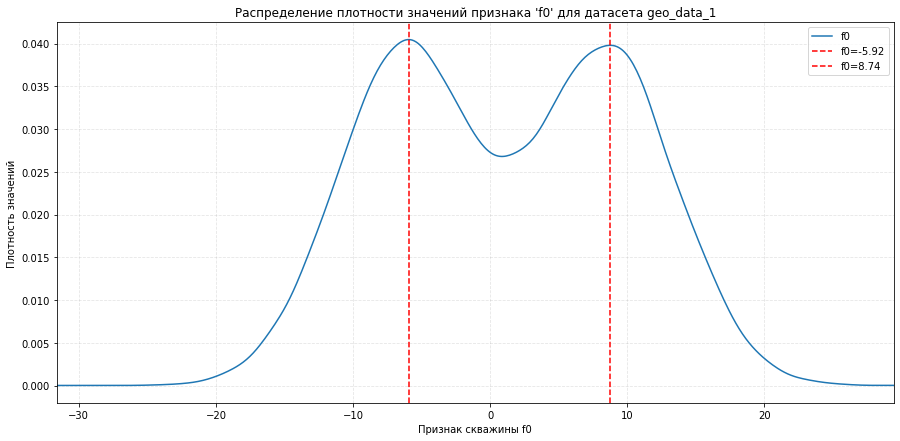

Пиковые значения: [-5.920212124066062, 8.741969409404547]

Распределение признака для датасета 'geo_data_2':


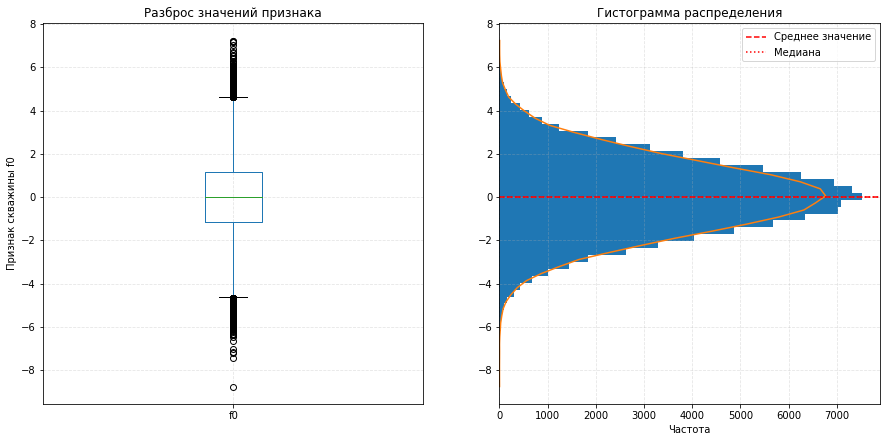

Описательная информация для признака 'f0':
Минимальное значение: -8.76 	|	Максимальное значение: 7.24
Среднее значение: 0.0
Медиана: 0.01
Межквартильный размах IQR: 2.32
Границы нормальных значений: от -4.64 до 4.64

Рассмотрим более подробно распределение значений:


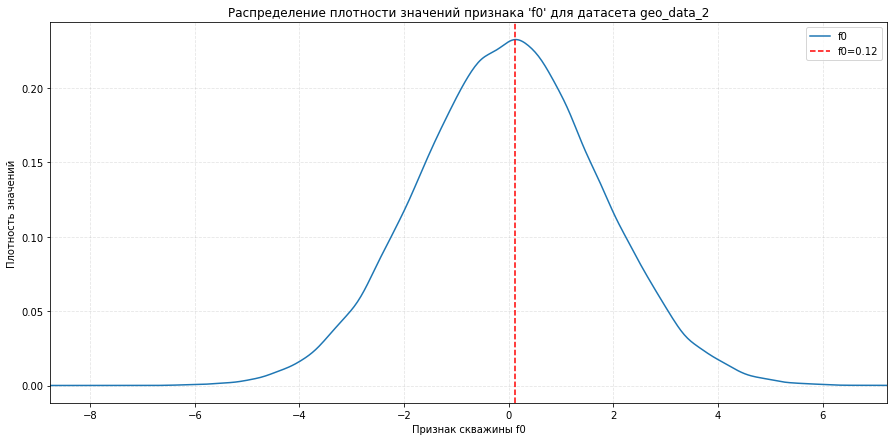

Пиковые значения: [0.11991484893171389]



In [16]:
feature = 'f0'

for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f"Распределение признака для датасета '{df.dsc}':")
    stat_num(df, feature)
    print(f"\nРассмотрим более подробно распределение значений:")
    feature_density_spread(df, feature)
    print()

**Вывод**:
Распределение признака `f0` отличается для рассматриваемых датасетов:
* Масштаб признака.
  * geo_data_0: значения варьируются от -1.41 до 2.36
  * geo_data_1: от -31.61 до 29.42
  * geo_data_2: от -8.76 до 7.24
* Для всех датасетов распределение близко к симметрии относительно 0.
* Тип распределения.
  * geo_data_0: Четырехмодальное, имеется 4 пиковых значения [-0.89, 0.11, 0.89, 1.89]
  * geo_data_1: Бимодальное, имеется 2 пиковых значения [-5.92, 8.74]
  * geo_data_2: Нормальное, имеется 1 пиковое значение  [0.12]
* Для рассматриваемых датасетов не наблюдается явно аномальных значений выходящих далеко за пределы нормальных границ.

[Вернуться к оглавлению](#point0)

### Признак `f1`
Отобразим распределение признака `f1` для рассматриваемых датасетов:

Распределение признака для датасета 'geo_data_0':


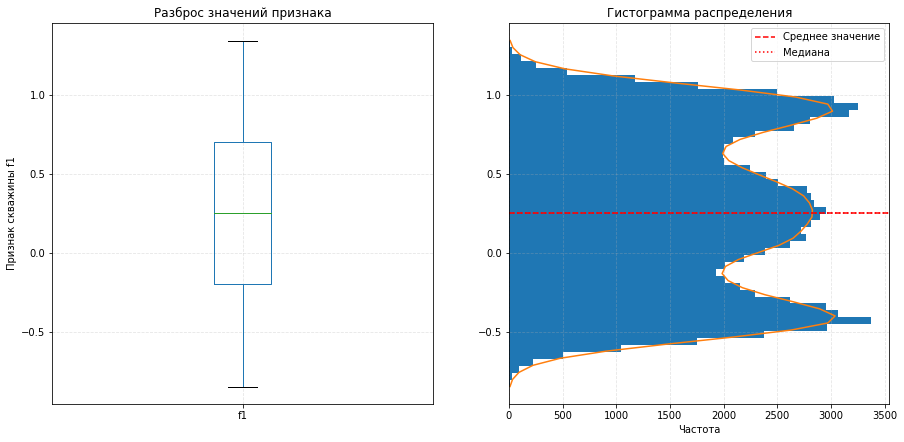

Описательная информация для признака 'f1':
Минимальное значение: -0.85 	|	Максимальное значение: 1.34
Среднее значение: 0.25
Медиана: 0.25
Межквартильный размах IQR: 0.9
Границы нормальных значений: от -0.85 до 1.34

Рассмотрим более подробно распределение значений:


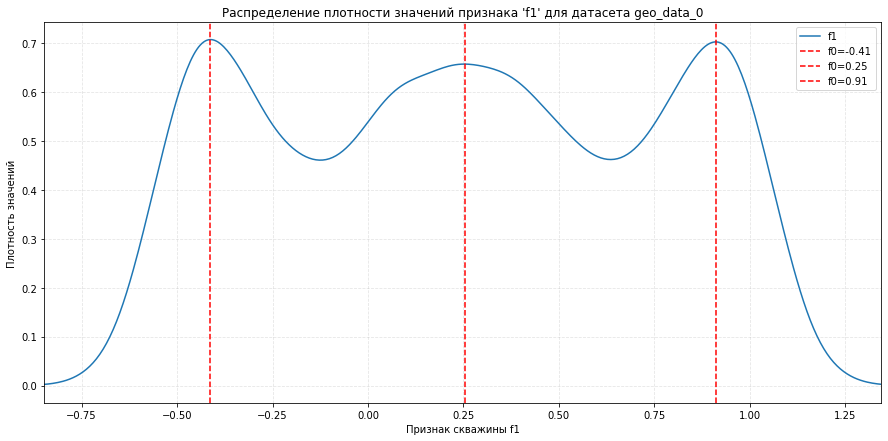

Пиковые значения: [-0.4126733674623475, 0.25435796443661607, 0.9126125682842781]

Распределение признака для датасета 'geo_data_1':


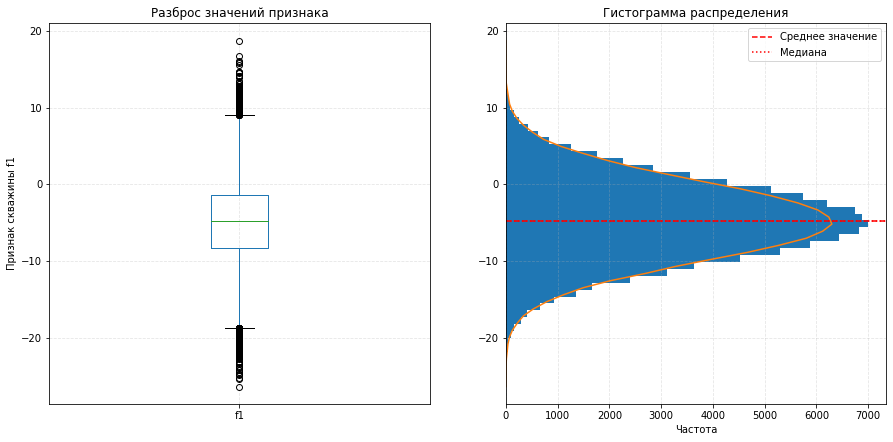

Описательная информация для признака 'f1':
Минимальное значение: -26.36 	|	Максимальное значение: 18.73
Среднее значение: -4.8
Медиана: -4.81
Межквартильный размах IQR: 6.94
Границы нормальных значений: от -18.67 до 9.07

Рассмотрим более подробно распределение значений:


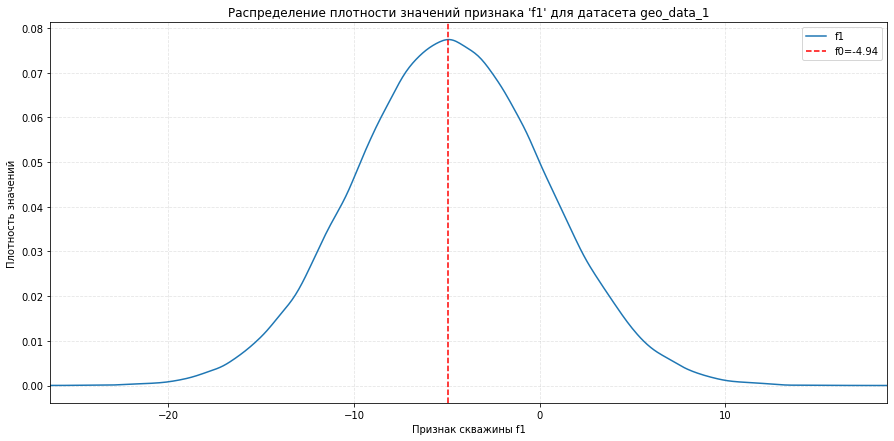

Пиковые значения: [-4.940712648320485]

Распределение признака для датасета 'geo_data_2':


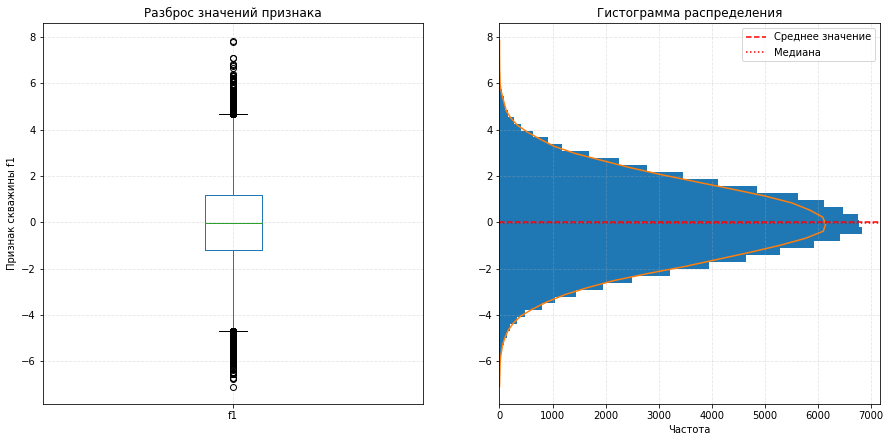

Описательная информация для признака 'f1':
Минимальное значение: -7.08 	|	Максимальное значение: 7.84
Среднее значение: -0.0
Медиана: -0.01
Межквартильный размах IQR: 2.34
Границы нормальных значений: от -4.68 до 4.67

Рассмотрим более подробно распределение значений:


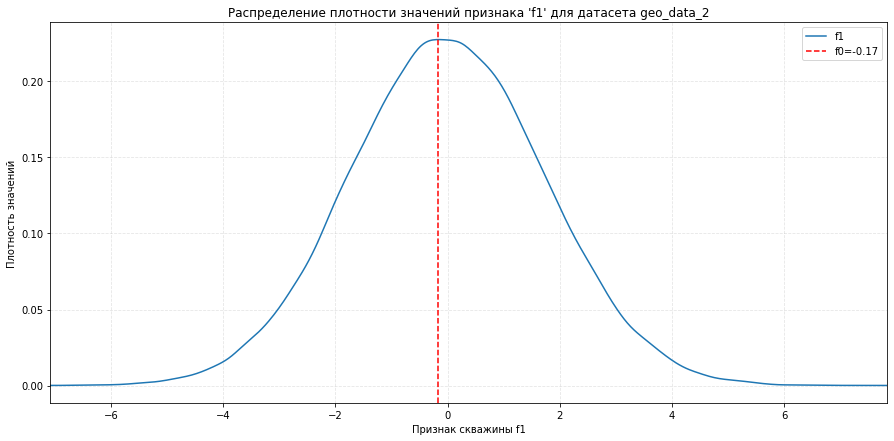

Пиковые значения: [-0.17252854283414187]



In [17]:
feature = 'f1'

for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f"Распределение признака для датасета '{df.dsc}':")
    stat_num(df, feature)
    print(f"\nРассмотрим более подробно распределение значений:")
    feature_density_spread(df, feature)
    print()

**Вывод**:
Распределение признака `f1` отличается для рассматриваемых датасетов:
* Масштаб признака.
  * geo_data_0: значения варьируются от -0.85 до 1.34
  * geo_data_1: от -26.36 до 18.73
  * geo_data_2: от -7.08 до 7.84
* Тип распределения.
  * geo_data_0: Трехмодальное, имеется 3 пиковых значения [-0.41, 0.25, 0.91]
  * geo_data_1: Нормальное, имеется 1 пиковое значение [-4.94]
  * geo_data_2: Нормальное, имеется 1 пиковое значение  [-0.17]
* Для рассматриваемых датасетов не наблюдается явно аномальных значений выходящих далеко за пределы нормальных границ.

[Вернуться к оглавлению](#point0)

### Признак `f2`
Отобразим распределение признака `f2` для рассматриваемых датасетов:

Распределение признака для датасета 'geo_data_0':


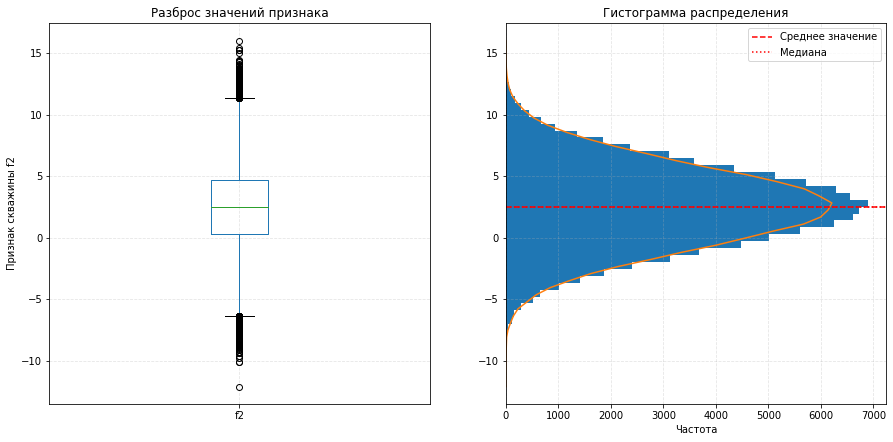

Описательная информация для признака 'f2':
Минимальное значение: -12.09 	|	Максимальное значение: 16.0
Среднее значение: 2.5
Медиана: 2.52
Межквартильный размах IQR: 4.43
Границы нормальных значений: от -6.35 до 11.36

Рассмотрим более подробно распределение значений:


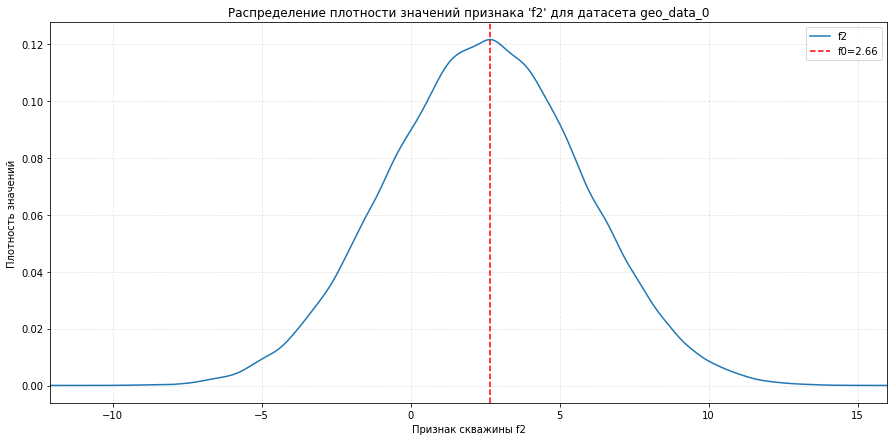

Пиковые значения: [2.6607369039190694]

Распределение признака для датасета 'geo_data_1':


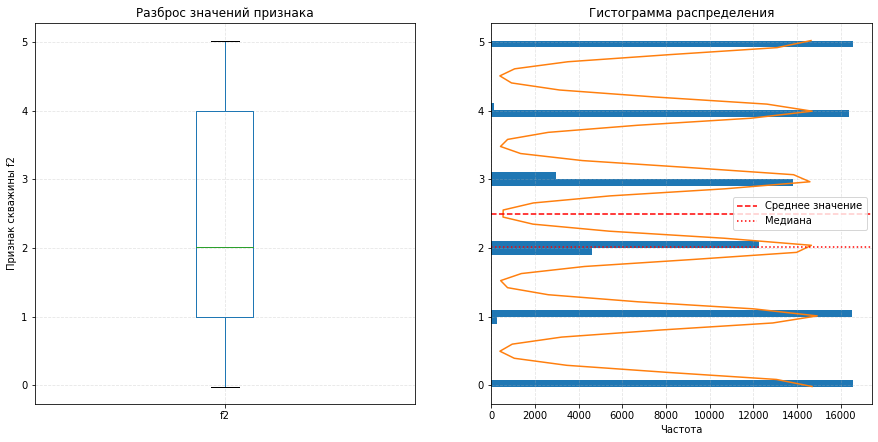

Описательная информация для признака 'f2':
Минимальное значение: -0.02 	|	Максимальное значение: 5.02
Среднее значение: 2.49
Медиана: 2.01
Межквартильный размах IQR: 3.0
Границы нормальных значений: от -0.02 до 5.02

Рассмотрим более подробно распределение значений:


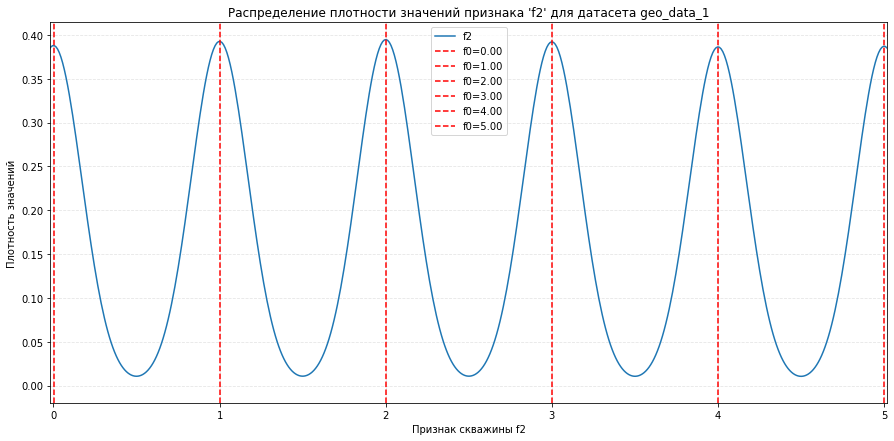

Пиковые значения: [0.004548997259266496, 1.0030446920574878, 2.001540386855709, 3.000036081653931, 3.9985317764521526, 4.997027471250373]

Распределение признака для датасета 'geo_data_2':


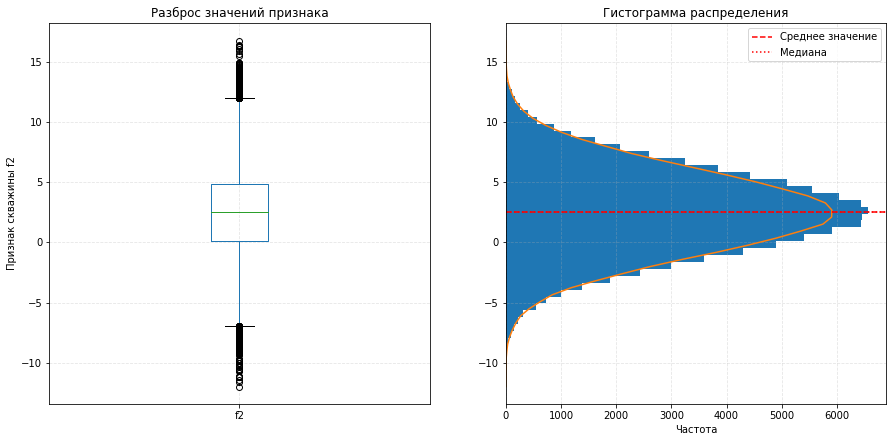

Описательная информация для признака 'f2':
Минимальное значение: -11.97 	|	Максимальное значение: 16.74
Среднее значение: 2.5
Медиана: 2.48
Межквартильный размах IQR: 4.73
Границы нормальных значений: от -6.96 до 11.95

Рассмотрим более подробно распределение значений:


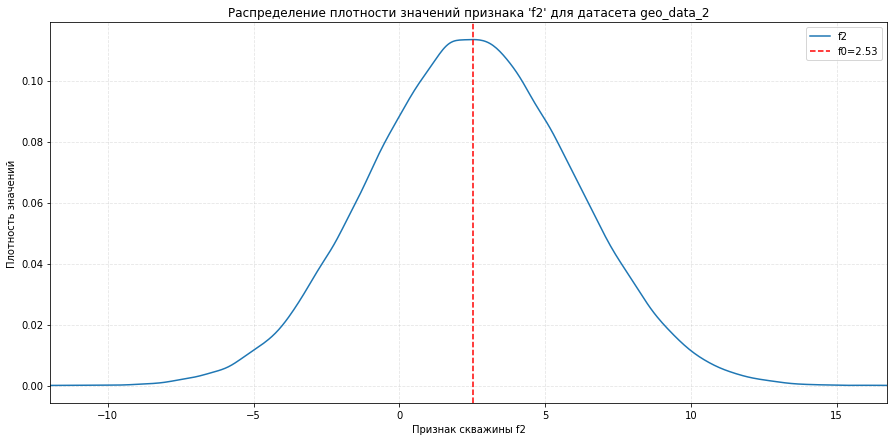

Пиковые значения: [2.5282261339875234]



In [18]:
feature = 'f2'

for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f"Распределение признака для датасета '{df.dsc}':")
    stat_num(df, feature)
    print(f"\nРассмотрим более подробно распределение значений:")
    feature_density_spread(df, feature)
    print()

**Вывод**:
Распределение признака `f2` отличается для рассматриваемых датасетов:
* Масштаб признака.
  * geo_data_0: значения варьируются от -12.09 до 16.0
  * geo_data_1: от -0.02 до 5.02
  * geo_data_2: от -11.97 до 16.74
* Тип распределения.
  * geo_data_0: Нормальное, имеется 1 пиковое значение [2.66]
  * geo_data_1: Мультимодальное, имеется 5 пиковых значений [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
  * geo_data_2: Нормальное, имеется 1 пиковое значение  [2.53]
* Таким образом, для geo_data_0 и geo_data_2 распределения признака `f2` схожи, но отличаются от распределения для geo_data_1
* Для рассматриваемых датасетов не наблюдается явно аномальных значений выходящих далеко за пределы нормальных границ.

[Вернуться к оглавлению](#point0)

### Признак `product`

Признак отображает объём запасов нефти в скважине (тыс. баррелей).  
<font color='red'>Целевой признак</font>.

Отобразим распределение признака `product` для рассматриваемых датасетов:

Распределение признака для датасета 'geo_data_0':


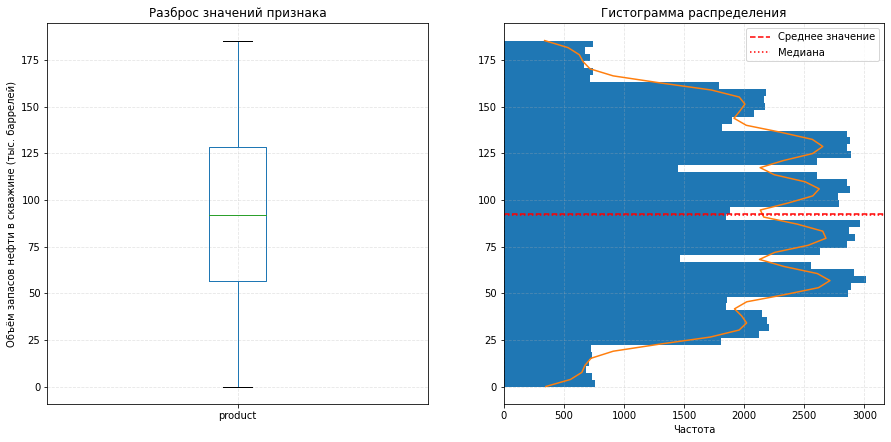

Описательная информация для признака 'product':
Минимальное значение: 0.0 	|	Максимальное значение: 185.36
Среднее значение: 92.5
Медиана: 91.85
Межквартильный размах IQR: 72.07
Границы нормальных значений: от 0.0 до 185.36

Рассмотрим более подробно распределение значений:


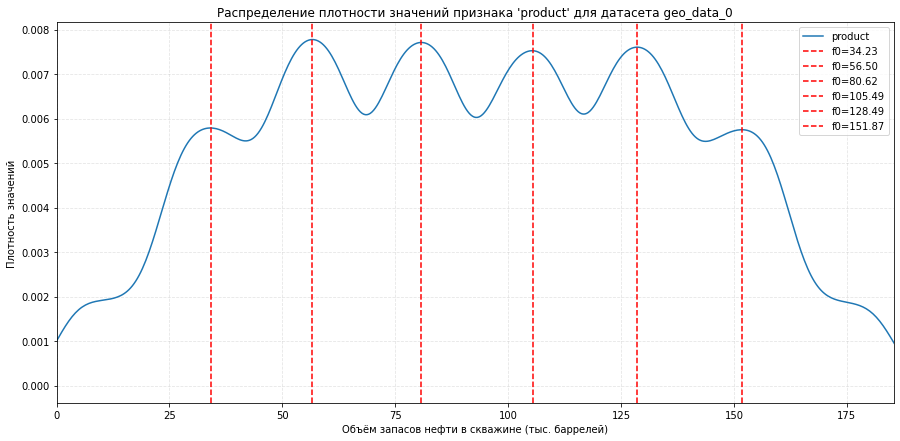

Пиковые значения: [34.2339560554685, 56.49994373382199, 80.62143038537161, 105.4851166261997, 128.49330389383164, 151.8725909561028]

Распределение признака для датасета 'geo_data_1':


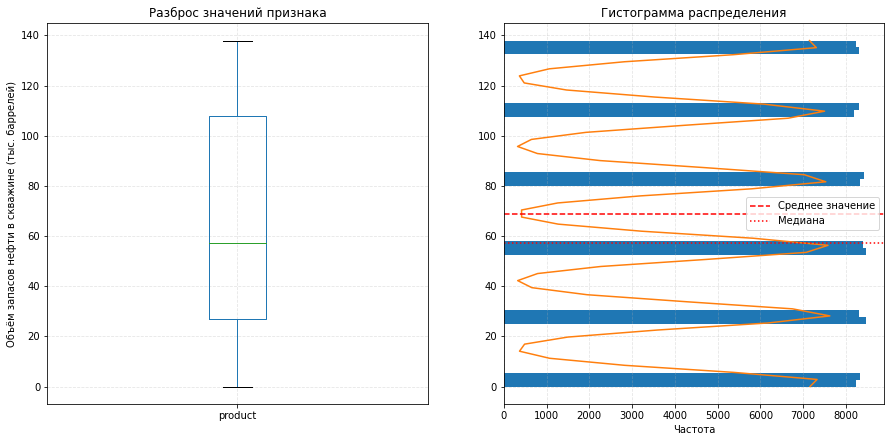

Описательная информация для признака 'product':
Минимальное значение: 0.0 	|	Максимальное значение: 137.95
Среднее значение: 68.83
Медиана: 57.09
Межквартильный размах IQR: 80.86
Границы нормальных значений: от 0.0 до 137.95

Рассмотрим более подробно распределение значений:


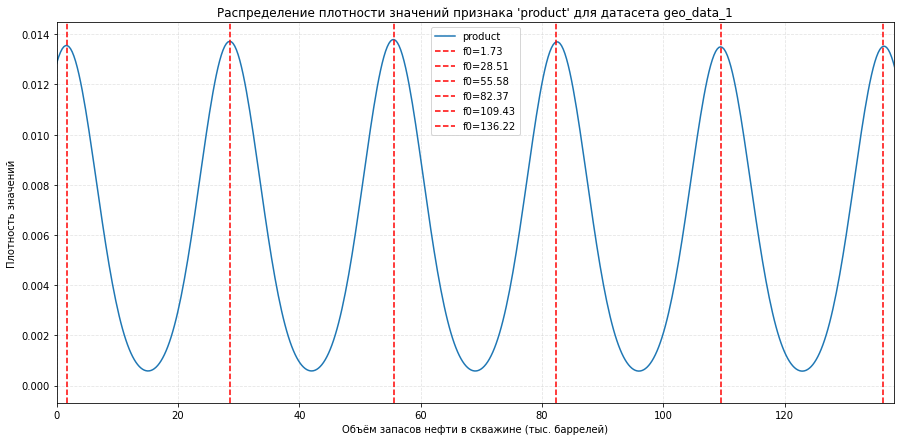

Пиковые значения: [1.726043640401727, 28.514240939436462, 55.57860522093546, 82.36680251997018, 109.4311668014692, 136.21936410050392]

Распределение признака для датасета 'geo_data_2':


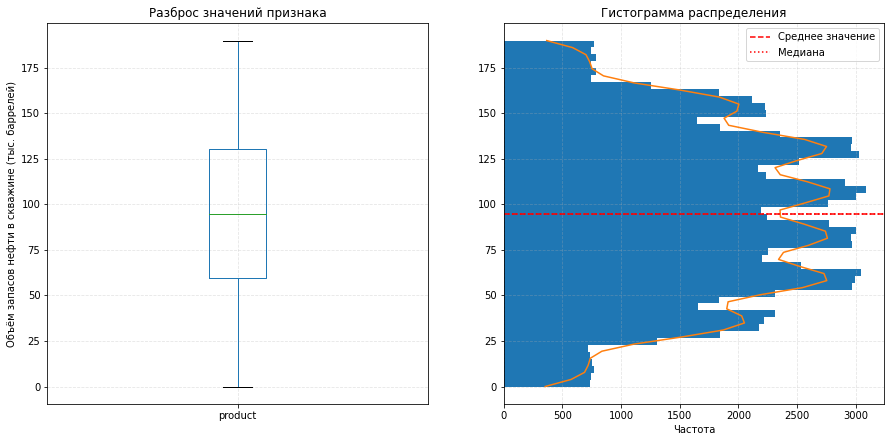

Описательная информация для признака 'product':
Минимальное значение: 0.0 	|	Максимальное значение: 190.03
Среднее значение: 95.0
Медиана: 94.93
Межквартильный размах IQR: 71.14
Границы нормальных значений: от 0.0 до 190.03

Рассмотрим более подробно распределение значений:


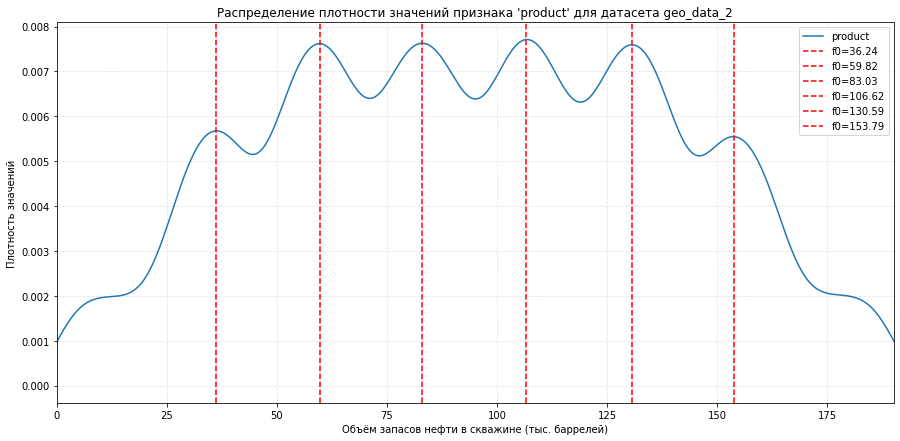

Пиковые значения: [36.23692112553397, 59.82420836735133, 83.0310554923652, 106.61834273418259, 130.58607009280348, 153.79291721781735]



In [19]:
feature = 'product'

for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(f"Распределение признака для датасета '{df.dsc}':")
    stat_num(df, feature)
    print(f"\nРассмотрим более подробно распределение значений:")
    feature_density_spread(df, feature)
    print()

**Вывод**:
Распределение признака `product` отличается для рассматриваемых датасетов:
* Масштаб признака.
  * geo_data_0: значения варьируются от 0.0 до 185.36
  * geo_data_1: от 0.0 до 137.95
  * geo_data_2: от 0.0 до 190.03
* Тип распределения.
  * geo_data_0: Мультимодальное, имеется 6 пиковых значений [34.23, 56.5, 80.62, 105.49, 128.49, 151.87]
  * geo_data_1: Мультимодальное, имеется 6 пиковых значений [1.73, 28.51, 55.58, 82.37, 109.43, 136.22]
  * geo_data_2: Мультимодальное, имеется 6 пиковых значений  [36.24, 59.82, 83.03, 106.62, 130.59, 153.79]
* Таким образом, для geo_data_0 и geo_data_2 распределения признака `product` схожи, но отличаются от распределения для geo_data_1
* Для рассматриваемых датасетов не наблюдается явно аномальных значений выходящих далеко за пределы нормальных границ.

[Вернуться к оглавлению](#point0)

## Корреляционный анализ
Отобразим матрицу диаграмм рассеяния для количественных признаков в имеющихся датасетах: 

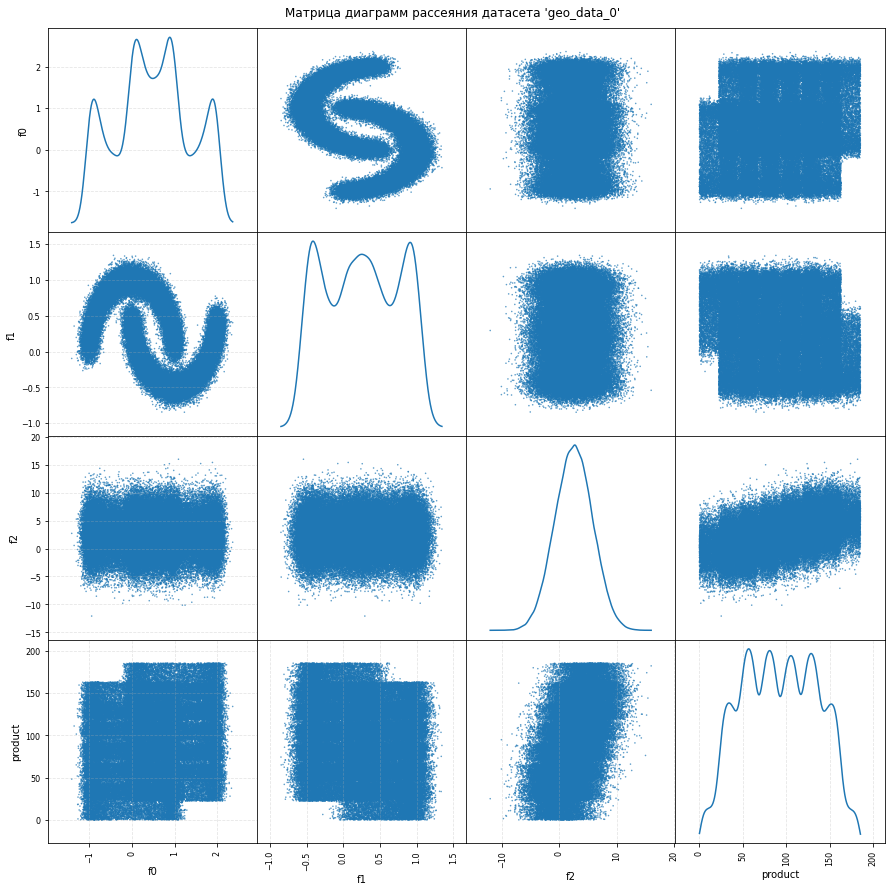

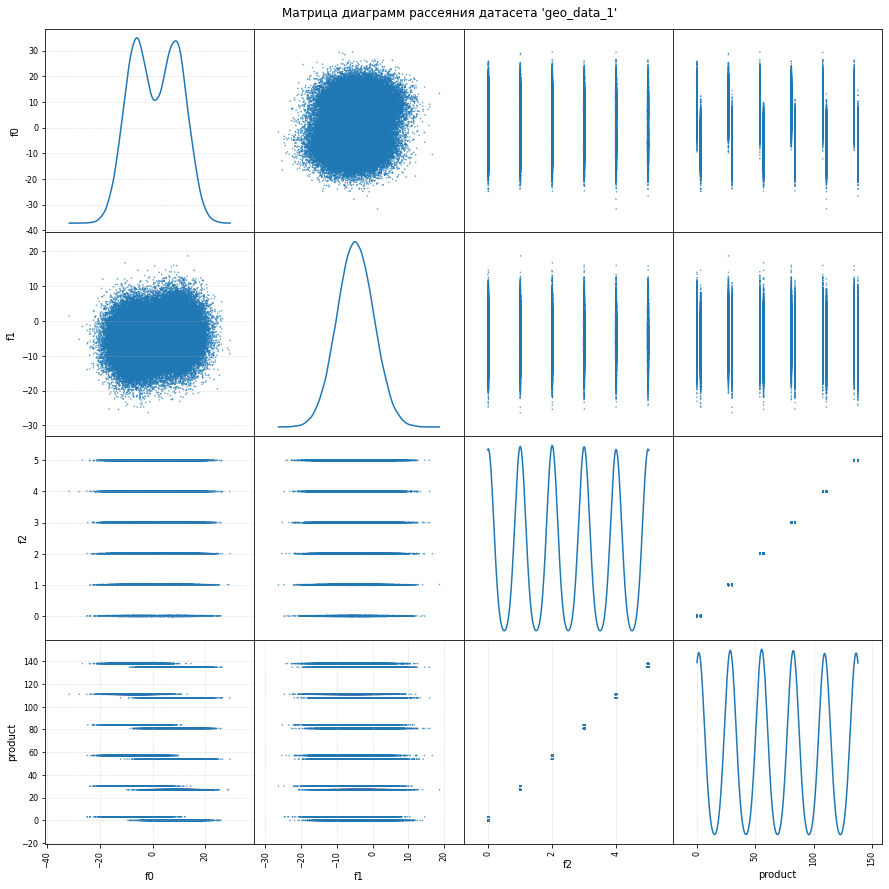

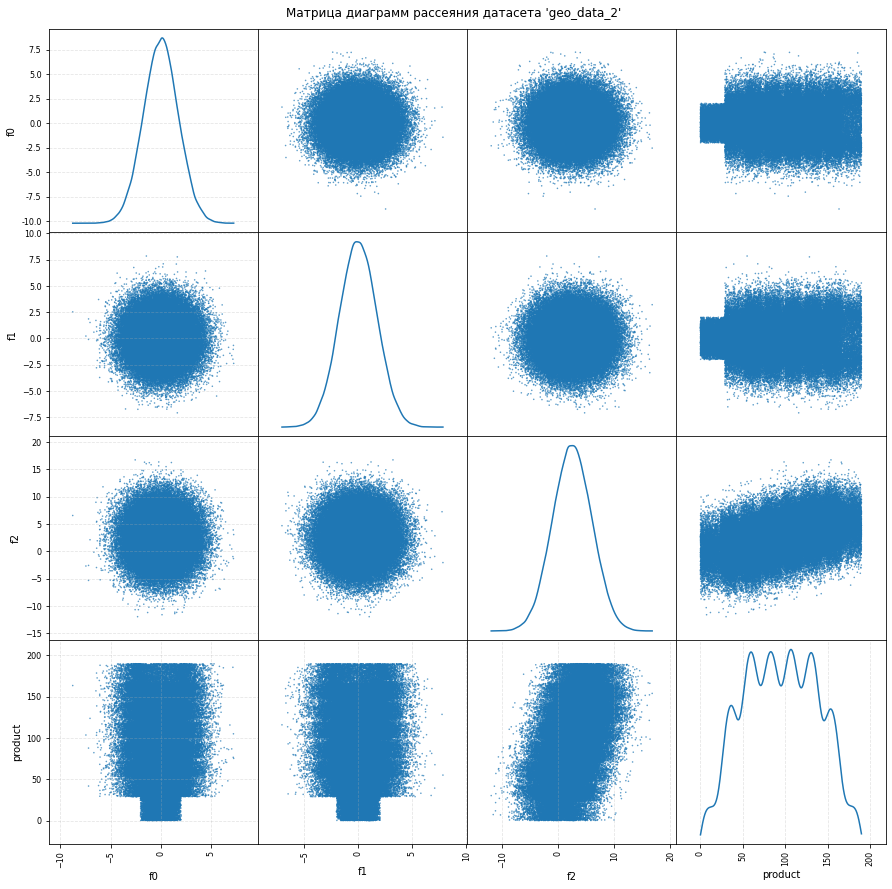

In [20]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    pd.plotting.scatter_matrix(df, s=10, alpha=0.7, figsize=(15, 15), diagonal='kde', range_padding=0.3)
    plt.suptitle(f"Матрица диаграмм рассеяния датасета '{df.dsc}'", y=0.9)
    plt.show()

Поскольку, обучающие и целевой признак являются **числовыми непрерывными величинами**, а по условию задачи требуется обучение модели **линейной регресии**, то для оценки взаимозависимости можно использовать коэффициент корреляции Пирсона.

Создадим матрицы корреляции на основе коэффициента Пирсона и отобразим их виде тепловых карт для наших данных:

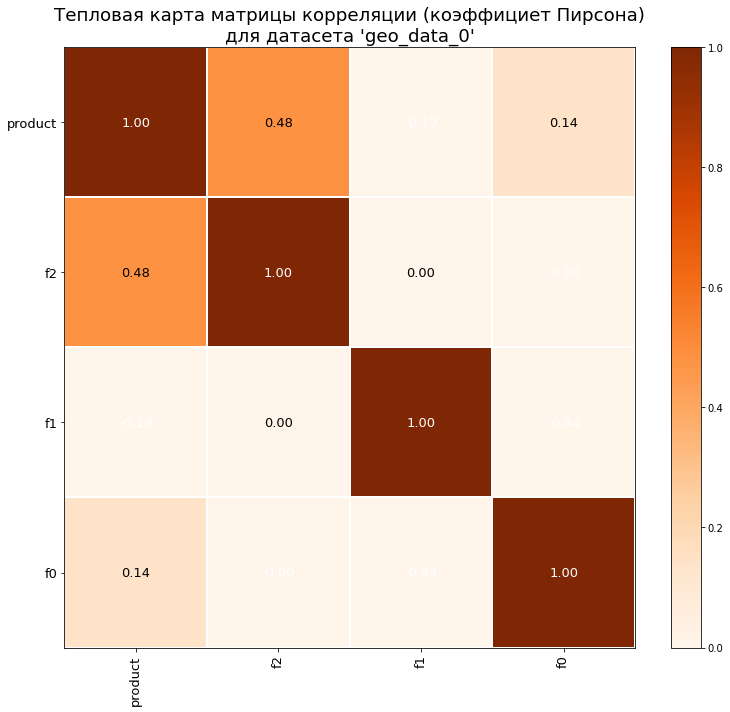

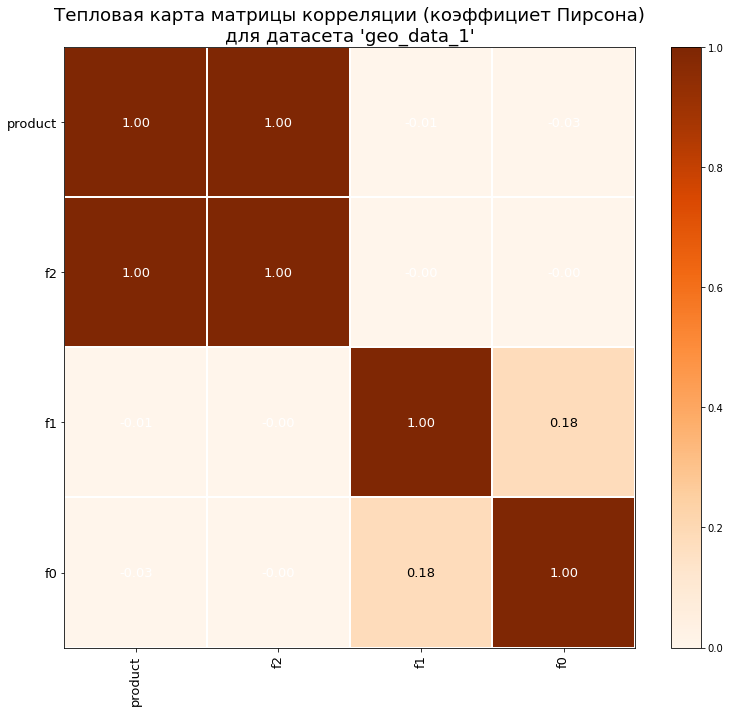

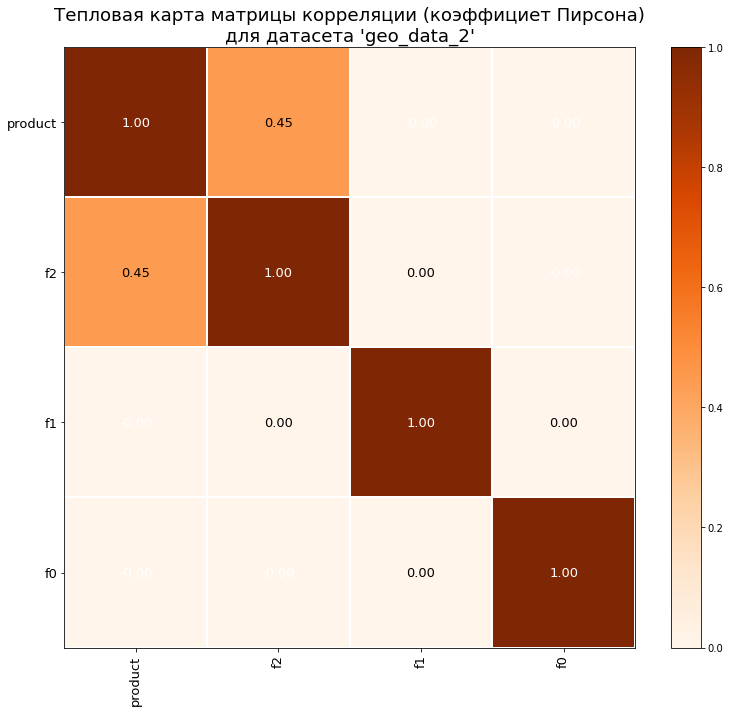

In [21]:
pearson_coef = []

for df in [geo_data_0, geo_data_1, geo_data_2]:
    data = df.drop('id', axis=1).corr()
    correlation_matrix_heatmap(data, 'pearson')
    pearson_coef.append(data['product'].to_list())

Коэффициент Пирсона учитывает только линейную зависимость признаков. Построим матрицы корреляции на основе коэффициента корреляции Фи, $\phi_{k}$, который также учитывает и нелинейную зависимость в данных:

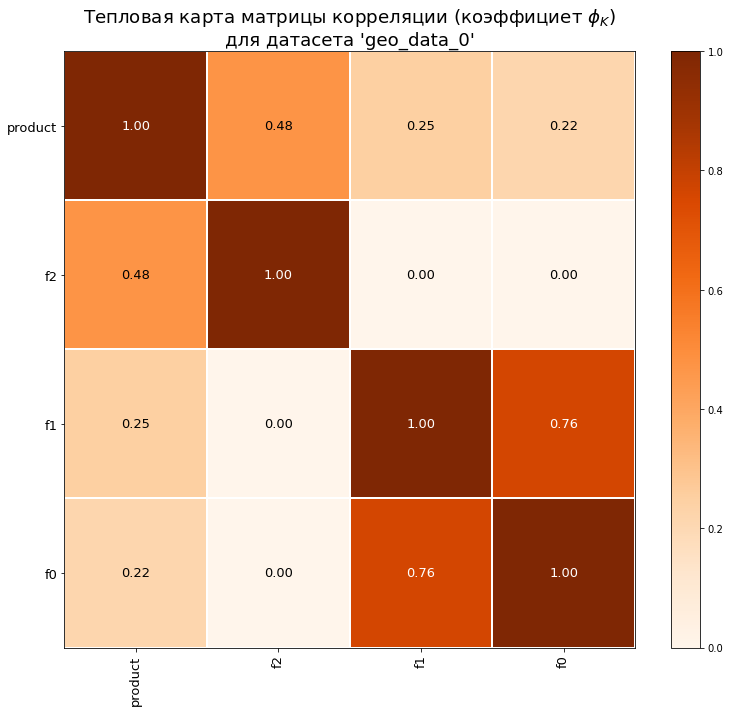

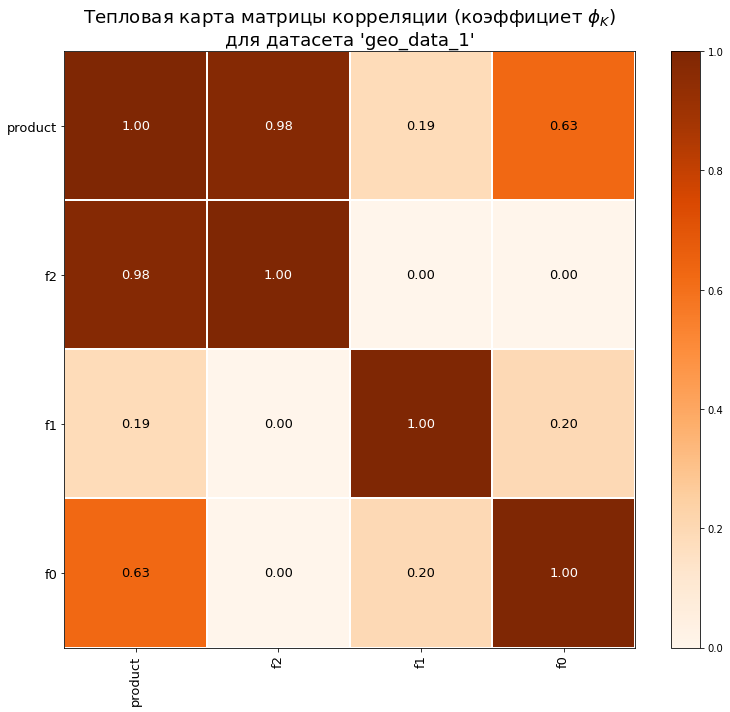

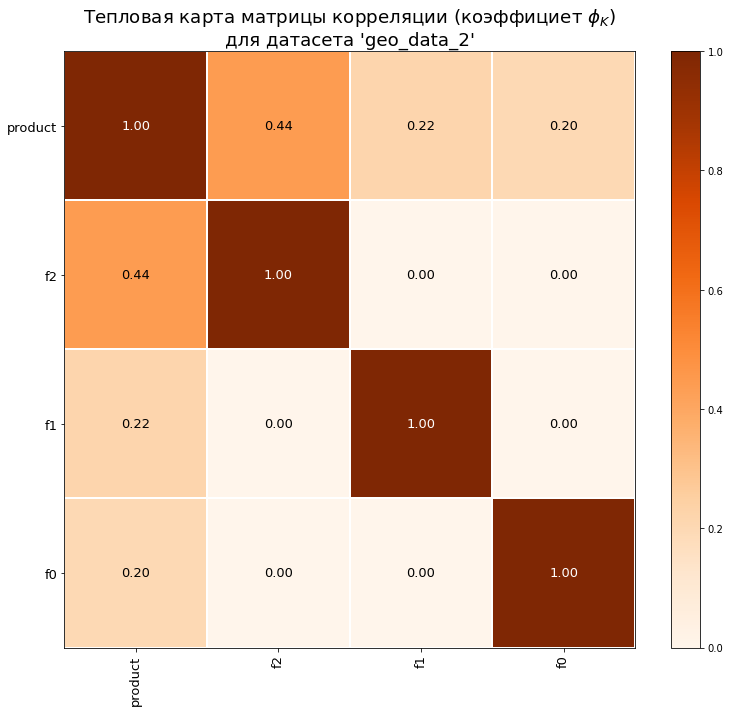

In [22]:
phi_coef = []
interval_cols = geo_data_0.drop('id', axis=1).columns.to_list()

for df in [geo_data_0, geo_data_1, geo_data_2]:
    data = df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
    correlation_matrix_heatmap(data, 'phi')
    phi_coef.append(data['product'].to_list())

Отобразим расчитанные коэффициенты корреляции для целевого и указанных обучающих признаков:

In [23]:
columns_list = geo_data_0.drop('id', axis=1).columns
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    data = pd.DataFrame({'коэф. Пирсона':pearson_coef[i], '$\phi_k$':phi_coef[i]}).transpose()
    data.columns = columns_list
    display(data.drop('product', axis=1).style.set_caption(f"Датасет '{df.dsc}':").highlight_max(axis=1))

,f0,f1,f2
коэф. Пирсона,0.143536,-0.192356,0.483663
$\phi_k$,0.215525,0.253544,0.475901


,f0,f1,f2
коэф. Пирсона,-0.030491,-0.010155,0.999397
$\phi_k$,0.628482,0.185965,0.978936


,f0,f1,f2
коэф. Пирсона,-0.001987,-0.001012,0.445871
$\phi_k$,0.201068,0.221022,0.443287


**Выводы**:
* Датасет `geo_data_0`:
  * Наибольшую корреляцию с целевым признаком показывает признак `f2`.
  * Причем он имеет примерно одинаковые коэффициенты Пирсона и $\phi_k$ - около 0.48, что указывает на умеренное линейное распределение признака.
  * Признаки `f0` и `f1` показывают слабую корреляцию. Можно отметить, что признак `f1` показывает отрицательную линейную зависимость, в то время как $\phi_k$ фиксирует положительную зависимость примерно такой же величины.
* Датасет `geo_data_1`:
  * Наибольшую корреляцию также показывает признак `f2`.
  * Снова его значение (0.98) примерно одинаково как для линейного коэффициента, так и для $\phi_k$.
  * Линейная зависимость `f0` и `f1` с целевым признаком практически отсутствует.
  * В то время как $\phi_k$ показывает для этих признаков слабую или даже заметную корреляцию.
* Датасет `geo_data_2`:
  * Наибольшую корреляцию также показывает признак `f2`.
  * Его значения коэффициента Пирсона и $\phi_k$ близки по значению и имеют примерно такую же величину (~0.44), как и в датасете `geo_data_0`.
  * Корреляция признаков `f0` и `f1` больше похожа на `geo_data_1` - линейная зависимость практически отсутствует, в то время как $\phi_k$ фиксирует слабую зависимость.

[Вернуться к оглавлению](#point0)

## Обучение моделей
Для решения задачи регрессии - предсказания объёма запасов нефти в новых скважинах - необходимо обучить модели и найти лучшую по точности предсказания.
* Целевой признак `product` - объём запасов нефти в скважине (тыс. баррелей).
* Обучающие признаки - `f0`, `f1`, `f2` - представлены числовыми непрерывными величинами.
* По условию задачи в качестве модели подходит только **Линейная регрессия**.

### Создание пайплайна
Поскольку подготовка и обучение моделей осуществляется отдельно для каждого региона, я автоматизирую выполнение этих операций с помощью функции `prepare_and_fit`. 

Поясню основные шаги:
* На вход функции `prepare_and_fit` подается датафрейм `df`.
* Обучающие признаки `X` задаются отбрасыванием столбцов `id`,`product`:
  * `X = df.drop(['id','product'], axis=1)`
* А целевой признак `y`:
  * `df['product']`
* `test_size = TEST_SIZE` - выборки делятся в пропорции <span style="border-width:2px; border-style:solid; border-color:#ddb62b; padding: 3px;">75% {обучающая}</span> + <span style="border-width:2px; border-style:solid; border-color:#d160c4; padding: 3px;">25% {валидационная}</span>.<br>**Соотношение задается условием задачи**.

In [24]:
TEST_SIZE = 0.25

* Поскольку для рассматриваемых датасетов мы имеем довольно сложное распределение целевого признака (см. анализ распределения признака: [3.4  Признак 'product'](#Признак-product)), чтобы при разбиении данных на обучающую и валидационную выборки сохранить характер распределения я использую стратификацию.
  * В нашем случае целевой признак - это числовая непрерывная величина, поэтому для возможности стратификации нужно разбить все значения на корзины: `y_binned = pd.cut(y, bins=10, labels=False)`
  * Я разбиваю данные на 10 корзин `bins=10`.
* `num_columns = X_train.columns.to_list()` - Задается список числовых колонок, в нашем случае это все колонки обучающих признаков.
* Создается общий пайплайн для подготовки данных:<br><blockquote><pre>data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)</pre></blockquote>
* Создается итоговый пайплайн: подготовка данных и модель. В качестве модели по умолчанию - задаем LinearRegression:<br><blockquote><pre>pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])</pre></blockquote>
* Создается сетка, содержающая набор моделей и их гиперпараметров:<br><blockquote><pre>param_grid = [
    \# словарь для модели LinearRegression
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]</pre></blockquote>
  * В качестве модели только LinearRegression.
  * Гиперпараметр `fit_intercept` (определяет, следует ли включать свободный член (интерсепт или смещение) в модель линейной регрессии) принимает значение `True` или `False`
  * `'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']` - к признакам применяется масштабирование (стандартизация или нормализация), либо данные остаются в исходном виде.
* Создаеся пайплайн с приминением автоматизированного поиска гиперпараметров GridSearchCV:<br><blockquote><pre>grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)</pre></blockquote>
  * Установка модели пайплайна по умолчанию `pipe_final`.
  * Применение заданной сетки гиперпараметров моделей `param_grid`.
  * `cv=5` - применяется кросс-валидация из 5 блоков
  * `n_jobs=-1` - количество вычислительных мощностей (чтобы считалось быстрее, указывают `-1`)
  * `scoring=rmse_scorer` - в качестве метрики качества моделей используется RMSE, это **задано условием проекта**.   
    * Метрика RMSE рассчитывается с помощью стандартной метрики MSE библиотеки `sklearn` с параметром `squared=False`, который представляет данные в виде корня;
    * Алгоритм метрики `rmse_scorer` задается как **поиск наименьшего значения** (опция `greater_is_better=False`)

In [25]:
# определение функции расчета метрики RMSE:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# определение алгоритма метрики:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

* Модель возвращает набор обучающих и целевого признаков для обучающих и валидационных данных, а также результаты обучения GridSearchCV.

Зададим функцию `prepare_and_fit`:

In [26]:
def prepare_and_fit(df):
    """
    Функция для подготовки данных и обучения модели
    """
    print(f"{df.dsc}.shape: {df.shape}")
    
    X = df.drop(['id','product'], axis=1)
    y = df['product']
    
    y_binned = pd.cut(y, bins=10, labels=False)    

    # разбиение обучающих и целевого признака на выборки:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE,
        stratify=y_binned)
    
    print(f"X_train.shape: {X_train.shape}; y_train.shape: {y_train.shape}")
    print(f"X_valid.shape: {X_valid.shape}; y_valid.shape: {y_valid.shape}")
    
    # Графики распределения целевого признака в выборках:
    y.plot.kde(label='y')
    y_train.plot.kde(label='y_train')
    y_valid.plot.kde(label='y_valid')
    plt.title(f"Распределение плотности значений целевого признака датасета '{df.dsc}' для полученных выборок")
    plt.xlabel(feature_dsc['product'])
    plt.ylabel("Плотность значений")
    plt.xlim(y.min(),y.max())
    plt.legend()
    plt.show()
    
    num_columns = X_train.columns.to_list()
    print(f"num_columns: {num_columns}")
    
    data_preprocessor = ColumnTransformer(
        [('num', MinMaxScaler(), num_columns)],
        remainder='passthrough'
    )
    
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ])
    
    param_grid = [
        # словарь для модели LinearRegression
        {
            'models': [LinearRegression()],
            'models__fit_intercept': [True, False],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        }
    ]
    
    grid_search = GridSearchCV(
        pipe_final,
        param_grid,
        cv=5,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print('\nЛучшая модель и её параметры:\n', grid_search.best_estimator_)
    print('Метрика RMSE лучшей модели на кросс-валидации:', -grid_search.best_score_)
    return X_train, X_valid, y_train, y_valid, grid_search

[Вернуться к оглавлению](#point0)

### Регион 0
#### Поиск лучшей модели
Произведем подготовку данных и поиск лучшей модели для датасета `geo_data_0`:

geo_data_0.shape: (100000, 5)
X_train.shape: (75000, 3); y_train.shape: (75000,)
X_valid.shape: (25000, 3); y_valid.shape: (25000,)


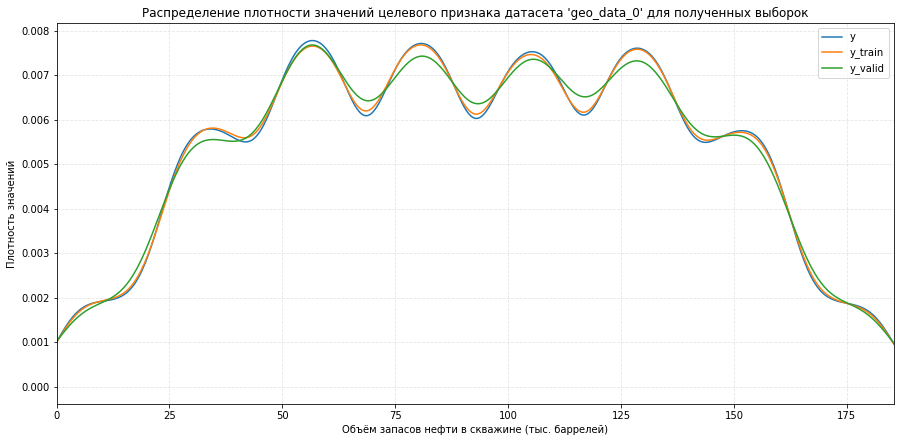

num_columns: ['f0', 'f1', 'f2']

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика RMSE лучшей модели на кросс-валидации: 37.711303589217685


In [27]:
X_train_0, X_valid_0, y_train_0, y_valid_0, grid_search_0 = prepare_and_fit(geo_data_0)

Отобразим 5 лучших результатов среди исследованных моделей:

In [28]:
show_best_5(grid_search_0)

,rank_test_score,param_models,mean_test_score,mean_fit_time,params
0,1,LinearRegression,37.7113,0.078084,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': StandardScaler()}"
1,1,LinearRegression,37.7113,0.096319,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': MinMaxScaler()}"
2,1,LinearRegression,37.7113,0.045396,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': 'passthrough'}"
4,4,LinearRegression,37.7388,0.116143,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': MinMaxScaler()}"
5,5,LinearRegression,61.0165,0.045850,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': 'passthrough'}"


[Вернуться к оглавлению](#point0)

#### Оценка качества модели на валидационных данных
Рассчитаем метрику лучшей модели на валидационных данных:

In [29]:
y_valid_pred_0 = grid_search_0.predict(X_valid_0)
rmse_valid_0 = rmse(y_valid_0, y_valid_pred_0)
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_0}')

Метрика RMSE на валидационной выборке: 37.63742948463151


Графически отобразим плотность распределения истинных и предсказанных значений целевого признака:

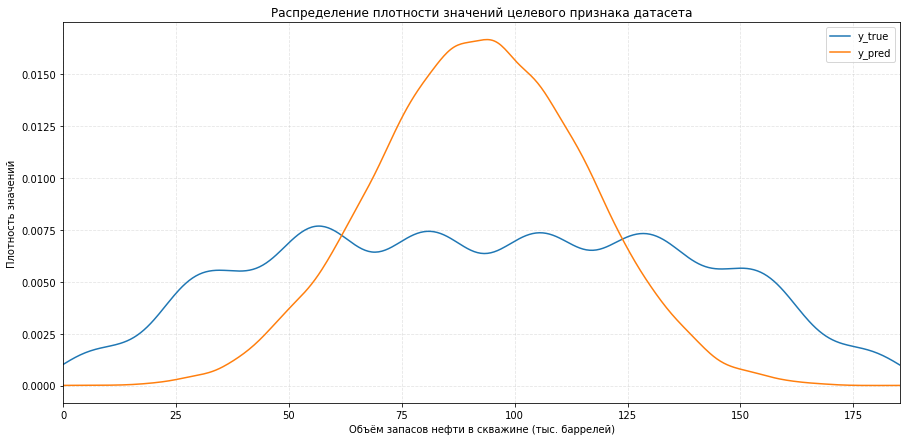

In [30]:
target_compare(y_valid_0, y_valid_pred_0)

[Вернуться к оглавлению](#point0)

#### Проверка модели на адекватность
Для проверки модели на адекватность я использую модель **DummyRegressor** из библиотеки `sklearn`. Данная модель формирует предсказания на простом принципе - заполняя значения какой-либо постоянной величиной - по умолчанию подставляя среднее значение (`mean`).

Задам процесс проверки функцией `dummy_check`:

In [31]:
def dummy_check(X_train, X_valid, y_train, y_valid, rmse_valid):
    # инициализация модели:
    dummy_model = DummyRegressor()

    # обучение модели на train-выборке:
    dummy_model.fit(X_train, y_train)

    # формирование предсказаний на основе признаков valid-выборки:
    dummy_predictions_valid = dummy_model.predict(X_valid)

    # расчет метрики:
    rmse_dummy = rmse(y_valid, dummy_predictions_valid)

    # оценка результата:
    if rmse_valid < rmse_dummy:
        print("✅ Модель прошла проверку на адекватность: метрика RMSE модели",
              f"'{grid_search_0.best_estimator_.steps[-1][1].__class__.__name__}' ({rmse_valid:.2f})",
              f"лучше, чем у случайной ({rmse_dummy:.2f})")
    else:
        print("Модель нуждается в доработке: метрика качества низкая 👎")

Проверим наши данные:

In [32]:
dummy_check(X_train_0, X_valid_0, y_train_0, y_valid_0, rmse_valid_0)

✅ Модель прошла проверку на адекватность: метрика RMSE модели 'LinearRegression' (37.64) лучше, чем у случайной (44.31)


[Вернуться к оглавлению](#point0)

#### Анализ результата
Отобразим основные полученные на валидационных данных результаты для региона 0:

In [33]:
print(f"Средний запас предсказанного сырья: {y_valid_pred_0.mean():.3f} (тыс. баррелей)")
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_0:.3f}')

Средний запас предсказанного сырья: 92.333 (тыс. баррелей)
Метрика RMSE на валидационной выборке: 37.637


**Выводы**. Для решения задачи регрессии - предсказания объёма запасов нефти в новых скважинах, на основе данных для *региона 0*, были исследованы модели машинного обучения и получены следующие результаты:
* Лучшую метрику показала модель LinearRegression со следующими гиперпараметрами: `{'models__fit_intercept': True, 'preprocessor__num': StandardScaler()}`.
* Значение метрики RMSE на кросс-валидации: 37.71
* Значение метрики RMSE на валидационной выборке: 37.64
* При графическом анализе распределения истинных и предсказанных значений видно, что модель не в достаточной мере отражает характер распределения данных. Это можно объяснить ограниченностью линейного алгоритма, напомню, что максимальный коэффициент Пирсона между обучающими и целевым признаками - около 0.48.
* Тем не менее, полученная модель прошла проверку на адекватность: метрика модели 'LinearRegression' (37.64) лучше, чем у случайной (44.31)
* Средний запас предсказанного сырья на валидационных данных: 92.333 (тыс. баррелей)

[Вернуться к оглавлению](#point0)

### Регион 1
#### Поиск лучшей модели
Произведем подготовку данных и поиск лучшей модели для датасета `geo_data_1`:

geo_data_1.shape: (100000, 5)
X_train.shape: (75000, 3); y_train.shape: (75000,)
X_valid.shape: (25000, 3); y_valid.shape: (25000,)


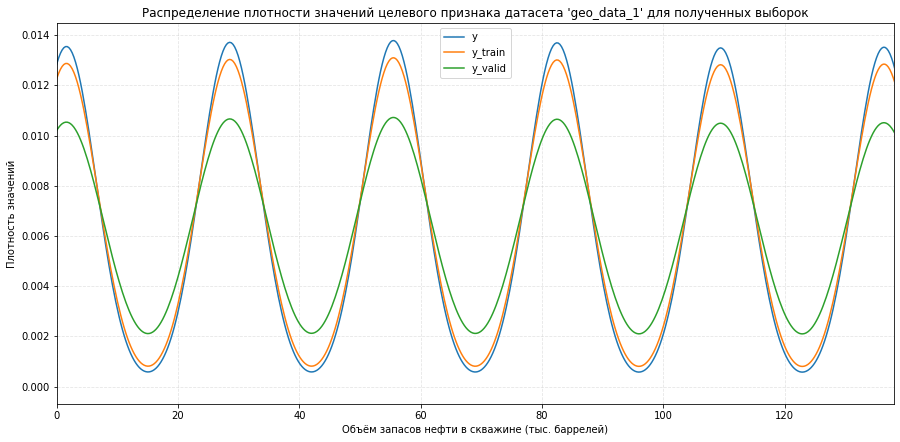

num_columns: ['f0', 'f1', 'f2']

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика RMSE лучшей модели на кросс-валидации: 0.8895322299182048


In [34]:
X_train_1, X_valid_1, y_train_1, y_valid_1, grid_search_1 = prepare_and_fit(geo_data_1)

Отобразим 5 лучших результатов среди исследованных моделей:

In [35]:
show_best_5(grid_search_1)

,rank_test_score,param_models,mean_test_score,mean_fit_time,params
0,1,LinearRegression,0.8895,0.081282,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': StandardScaler()}"
1,2,LinearRegression,0.8895,0.097655,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': MinMaxScaler()}"
2,2,LinearRegression,0.8895,0.010656,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': 'passthrough'}"
5,4,LinearRegression,1.2076,0.045603,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': 'passthrough'}"
4,5,LinearRegression,1.4593,0.116063,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': MinMaxScaler()}"


#### Оценка качества модели на валидационных данных
Рассчитаем метрику лучшей модели на валидационных данных:

In [36]:
y_valid_pred_1 = grid_search_1.predict(X_valid_1)
rmse_valid_1 = rmse(y_valid_1, y_valid_pred_1)
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_1}')

Метрика RMSE на валидационной выборке: 0.892904108914744


Графически отобразим плотность распределения истинных и предсказанных значений целевого признака:

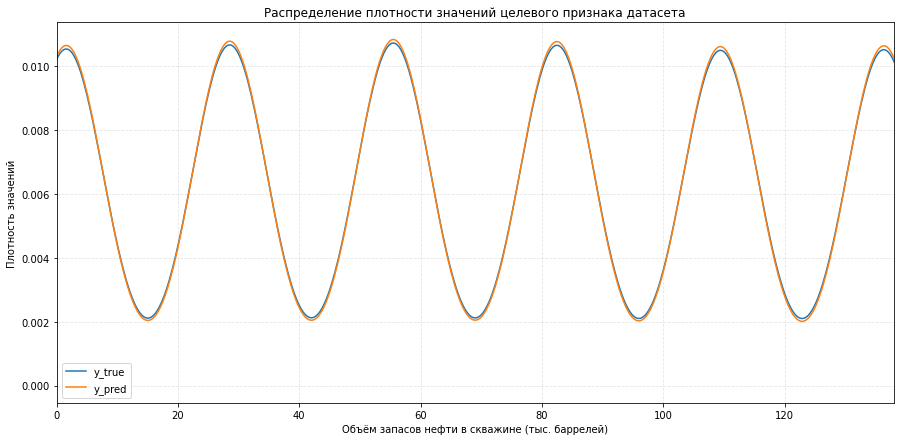

In [37]:
target_compare(y_valid_1, y_valid_pred_1)

[Вернуться к оглавлению](#point0)

#### Проверка модели на адекватность
Проверим модель на адекватность:

In [38]:
dummy_check(X_train_1, X_valid_1, y_train_1, y_valid_1, rmse_valid_1)

✅ Модель прошла проверку на адекватность: метрика RMSE модели 'LinearRegression' (0.89) лучше, чем у случайной (45.94)


[Вернуться к оглавлению](#point0)

#### Анализ результата
Отобразим основные полученные на валидационных данных результаты для региона 1:

In [39]:
print(f"Средний запас предсказанного сырья: {y_valid_pred_1.mean():.3f} (тыс. баррелей)")
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_1:.3f}')

Средний запас предсказанного сырья: 68.822 (тыс. баррелей)
Метрика RMSE на валидационной выборке: 0.893


**Выводы**. Для решения задачи регрессии - предсказания объёма запасов нефти в новых скважинах, на основе данных для *региона 1*, были исследованы модели машинного обучения и получены следующие результаты:
* Лучшую метрику показала модель LinearRegression со следующими гиперпараметрами: `{'models__fit_intercept': True, 'preprocessor__num': MinMaxScaler()}`.
* Значение метрики RMSE на кросс-валидации: 0.89
* Значение метрики RMSE на валидационной выборке: 0.89
* При графическом анализе распределения истинных и предсказанных значений видно, что модель достаточно хорошо отражает характер распределения данных. Это можно объяснить тем, что для рассматриваемых данных максималный коэффициент корреляции Пирсона равен 0.98, то есть данные показывают высокую степень линейной корреляции.
* Полученная модель прошла проверку на адекватность: метрика модели 'LinearRegression' (0.89) лучше, чем у случайной (45.94)
* Средний запас предсказанного сырья на валидационных данных: 68.822 (тыс. баррелей)

[Вернуться к оглавлению](#point0)

### Регион 2
#### Поиск лучшей модели
Произведем подготовку данных и поиск лучшей модели для датасета `geo_data_2`:

geo_data_2.shape: (100000, 5)
X_train.shape: (75000, 3); y_train.shape: (75000,)
X_valid.shape: (25000, 3); y_valid.shape: (25000,)


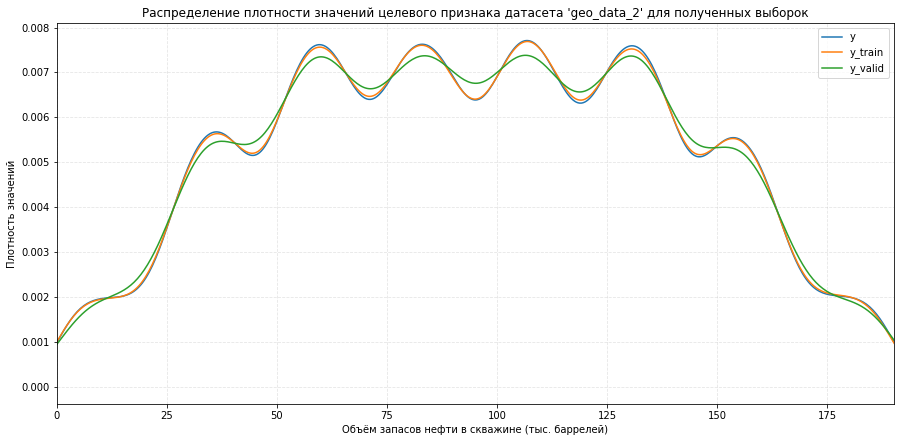

num_columns: ['f0', 'f1', 'f2']

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика RMSE лучшей модели на кросс-валидации: 40.02713579504524


In [40]:
X_train_2, X_valid_2, y_train_2, y_valid_2, grid_search_2 = prepare_and_fit(geo_data_2)

Отобразим 5 лучших результатов среди исследованных моделей:

In [41]:
show_best_5(grid_search_2)

,rank_test_score,param_models,mean_test_score,mean_fit_time,params
0,1,LinearRegression,40.0271,0.074566,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': StandardScaler()}"
1,1,LinearRegression,40.0271,0.134485,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': MinMaxScaler()}"
2,1,LinearRegression,40.0271,0.045810,"{'models': LinearRegression(), 'models__fit_intercept': True, 'preprocessor__num': 'passthrough'}"
4,4,LinearRegression,40.0617,0.136210,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': MinMaxScaler()}"
5,5,LinearRegression,76.7563,0.045312,"{'models': LinearRegression(), 'models__fit_intercept': False, 'preprocessor__num': 'passthrough'}"


[Вернуться к оглавлению](#point0)

#### Оценка качества модели на валидационных данных
Рассчитаем метрику лучшей модели на валидационных данных:

In [42]:
y_valid_pred_2 = grid_search_2.predict(X_valid_2)
rmse_valid_2 = rmse(y_valid_2, y_valid_pred_2)
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_2}')

Метрика RMSE на валидационной выборке: 40.148508176280814


Графически отобразим плотность распределения истинных и предсказанных значений целевого признака:

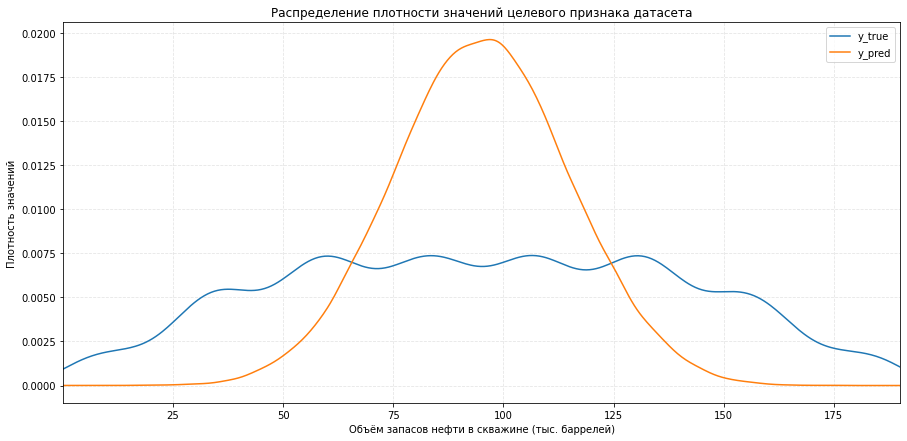

In [43]:
target_compare(y_valid_2, y_valid_pred_2)

[Вернуться к оглавлению](#point0)

#### Проверка модели на адекватность
Проверим модель на адекватность:

In [44]:
dummy_check(X_train_2, X_valid_2, y_train_2, y_valid_2, rmse_valid_2)

✅ Модель прошла проверку на адекватность: метрика RMSE модели 'LinearRegression' (40.15) лучше, чем у случайной (44.76)


[Вернуться к оглавлению](#point0)

#### Анализ результата
Отобразим основные полученные на валидационных данных результаты для региона 0:

In [45]:
print(f"Средний запас предсказанного сырья: {y_valid_pred_2.mean():.3f} (тыс. баррелей)")
print(f'Метрика RMSE на валидационной выборке: {rmse_valid_2:.3f}')

Средний запас предсказанного сырья: 95.006 (тыс. баррелей)
Метрика RMSE на валидационной выборке: 40.149


**Выводы**. Для решения задачи регрессии - предсказания объёма запасов нефти в новых скважинах, на основе данных для *региона 2*, были исследованы модели машинного обучения и получены следующие результаты:
* Лучшую метрику показала модель LinearRegression со следующими гиперпараметрами: `{'models__fit_intercept': True, 'preprocessor__num': StandardScaler()}`.
* Значение метрики RMSE на кросс-валидации: 40.02
* Значение метрики RMSE на валидационной выборке: 40.15
* При графическом анализе распределения истинных и предсказанных значений видно, что модель не в достаточной мере отражает характер распределения данных. Это можно объяснить ограниченностью линейного алгоритма. Максимальный коэффициент корреляции Пирсона ~0.44.
* Тем не менее, полученная модель прошла проверку на адекватность: метрика модели 'LinearRegression' (40.15) лучше, чем у случайной (44.77)
* Средний запас предсказанного сырья на валидационных данных: 95.012 (тыс. баррелей)

Отобразим сводный результат по всем регионам:

In [46]:
data_overview = pd.DataFrame({'Средний запас предсказанного сырья':[y_valid_pred_0.mean(), 
                                                                    y_valid_pred_1.mean(), 
                                                                    y_valid_pred_2.mean()],
                              'Метрика RMSE':[rmse_valid_0, rmse_valid_1, rmse_valid_2]}, 
                             index=['Регион 0','Регион 1','Регион 2']).transpose()
data_overview

,Регион 0,Регион 1,Регион 2
Средний запас предсказанного сырья,92.33,68.82,95.01
Метрика RMSE,37.64,0.89,40.15


**Выводы**:
* По среднему запасу предсказанного сырья лидируют *регион 0* и *регион 2* с показателями 92 и 95 тыс. баррелей.
* *Регион 1* по данному показателю уступает - лишь около 69 тыс. баррелей.
* Однако, следует также учесть разницу в величине метрик - для *региона 1* данные получены с довольно высокой точностью, RMSE=0.89.
* В то время как метрика RMSE для *региона 0* и *региона 2* лишь немного выше, чем у Dummy-модели, RMSE около 40.

[Вернуться к оглавлению](#point0)

## Расчет прибыли и рисков
Сформируем переменные, содержащие ключевые значения для расчётов:

Переменная|Описание
-|-
`UNITS_RESEARCH`|Количество точек исследования при разведке региона
`UNITS_DEVELOP`|Количество точек для разработки
`BUDGET_PER_REGION`|Бюджет на разработку скважин в регионе, руб.
`PROFIT_PER_UNIT`|Доход с каждой единицы продукта, руб.
`LOSS_PROBA`|Вероятность убытков

In [47]:
UNITS_RESEARCH = 500
UNITS_DEVELOP = 200
BUDGET_PER_REGION = 10_000_000_000
PROFIT_PER_UNIT = 450_000
LOSS_PROBA = 2.5

### Определение достаточного объёма сырья для безубыточной разработки новой скважины
Для каждого региона будет отбираться 200 (`UNITS_DEVELOP`) точек для разработки новых скважин.  
Рассчитаем средний бюджет на разработку одной скважины:

In [48]:
budget_per_unit = BUDGET_PER_REGION / UNITS_DEVELOP
print(f"Средний бюджет на разработку одной скважины: {budget_per_unit:,.2f} руб.")

Средний бюджет на разработку одной скважины: 50,000,000.00 руб.


Нам известен доход с одной единицы продукта и бюджет для одной скважины, следовательно, можно рассчитать минимальный объем добычи для  <abbr title="Убыток — это отрицательная прибыль.">безубыточной</abbr> разработки новой скважины и для целого региона:

In [49]:
min_product_unit   = budget_per_unit   / PROFIT_PER_UNIT
min_product_region = BUDGET_PER_REGION / PROFIT_PER_UNIT
print(f"Минимальный объем добычи для безубыточной разработки новой скважины: {min_product_unit:.2f} тыс. баррелей")
print(f"Минимальный безубыточный объем добычи для региона: {min_product_region:.2f} тыс. баррелей")

Минимальный объем добычи для безубыточной разработки новой скважины: 111.11 тыс. баррелей
Минимальный безубыточный объем добычи для региона: 22222.22 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе:

In [50]:
for c in data_overview.columns:
    stock_mean = data_overview.loc['Средний запас предсказанного сырья', c]
    if stock_mean >= min_product_unit: v = green + 'больше' + end
    else: v = red + 'меньше' + end
    print(f"Средний запас предсказанного сырья для '{c}'",
          f"равный {stock_mean:.2f} {v} минимального безубыточного порога {min_product_unit:.2f}")

Средний запас предсказанного сырья для 'Регион 0' равный 92.33 меньше минимального безубыточного порога 111.11
Средний запас предсказанного сырья для 'Регион 1' равный 68.82 меньше минимального безубыточного порога 111.11
Средний запас предсказанного сырья для 'Регион 2' равный 95.01 меньше минимального безубыточного порога 111.11


Отобразим относительное распределение *предсказанных значений* целевого признака превышающих минимальный порог безубыточной добычи для рассматриваемых регионов:

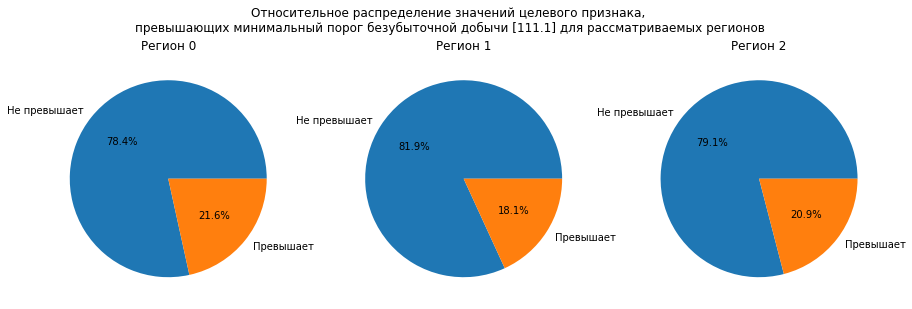

In [51]:
threshold_rate_compare(y_valid_pred_0, y_valid_pred_1, y_valid_pred_2)

**Выводы**:
* Для заданных условий рассчитан минимальный порог добычи для безубыточной разработки новой скважины, равный 111.11 тыс. баррелей.
* Для всех рассматриваемых регионов среднее значение предсказанной добычи меньше порогового.
* Для *региона 1* доля скважин со значением добычи выше порогового составляет около 18%.
* А для *региона 0* и *региона 2* около 21%

[Вернуться к оглавлению](#point0)

### Определение функции для расчета прибыли
Для расчёта прибыли по выбранным скважинам и предсказаниям модели необходимо задать функцию со следующей логикой:
1. Выбрать скважины с максимальными значениями предсказаний. 
2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитать прибыль для полученного объёма сырья.

Для удобства расчета и представления информации я создам новые датасеты содержащие реальные и предсказанные значения целевого признака:

In [52]:
target_0 = pd.DataFrame({'y_true':y_valid_0, 'y_pred':y_valid_pred_0})
target_1 = pd.DataFrame({'y_true':y_valid_1, 'y_pred':y_valid_pred_1})
target_2 = pd.DataFrame({'y_true':y_valid_2, 'y_pred':y_valid_pred_2})

Определим функцию для расчета прибыли:

In [53]:
def profit_calc(df):
    """
    Функция для расчета прибыли добычи топ-200 скважин
    """
    # 1. Определение индексов топ-200 скважин:
    # - датасет сортируется по убыванию предсказанных 'y_pred' значений
    # - индексы переводятся в список
    top_200_index = df.sort_values(by='y_pred', ascending=False).index.to_list()
    
    # 2. Расчет суммы рельных значений добычи:
    # - отбирается первые 200 {UNITS_DEVELOP} значений с найденными индексами top_200_index
    # - суммируются реальные 'y_true' значения датасета 
    top_200_product_sum = df.loc[top_200_index]['y_true'].head(UNITS_DEVELOP).sum()
    
    # 3. Расчет прибыли:
    # - из суммарного объема добычи top_200 вычитаем минимальный объем безубыточной добычи для региона
    # - разность умножаем на доход с каждой единицы продукта
    top_200_profit = (top_200_product_sum - min_product_region) * PROFIT_PER_UNIT
    
    return top_200_profit

**Вывод**: Задана функция для расчета прибыли по выбранным скважинам и предсказаниям модели, согласно условиям задания

[Вернуться к оглавлению](#point0)

### Расчет прибыли и рисков для каждого региона
Для расчете прибыли и рисков для каждого региона применим технику *Bootstrap* с 1000 выборок.

Зададим функцию `bootstrap`:

In [54]:
state = np.random.RandomState(RANDOM_STATE)

def bootstrap(df):
    """Бутстреп функция"""
    
    values = []
    for i in range(1000):
        subsample = df.sample(UNITS_RESEARCH, replace=True, random_state=state)
        values.append(profit_calc(subsample))
    return pd.Series(values)

Где:
* `replace=True` - опция для обеспечения *выбора элементов с возвращением* при создании подвыборок. То есть один и тот же элемент может попадать в подвыборку несколько раз.
* `random_state=np.random.RandomState(RANDOM_STATE)` - объект `RandomState()` из модуля `numpy.random` обеспечивает случайное состояние при каждом новом вызове. Воспроизводимость случайных состояний фиксируется глобальной переменной `RANDOM_STATE`.

Проведем процедуру бутстреп для наших данных:

In [55]:
profit_0 = bootstrap(target_0)
profit_1 = bootstrap(target_1)
profit_2 = bootstrap(target_2)

Представим результат:

In [56]:
(pd.DataFrame({'Средняя прибыль':[profit_0.mean(), profit_1.mean(), profit_2.mean()],
  '95%-й доверительный интервал':[f"{profit_0.quantile(0.025):,.2f} ... {profit_0.quantile(0.975):,.2f}",
                                  f"{profit_1.quantile(0.025):,.2f} ... {profit_1.quantile(0.975):,.2f}",
                                  f"{profit_2.quantile(0.025):,.2f} ... {profit_2.quantile(0.975):,.2f}"],
               'Риск убытков, %':[100 * (profit_0 < 0).mean(), 
                                  100 * (profit_1 < 0).mean(), 
                                  100 * (profit_2 < 0).mean()]},
             ['Регион 0','Регион 1','Регион 2'])
.style
 .format({'Средняя прибыль': '{:,.2f}', 'Риск убытков, %': '{:,.2f}'})
 .bar(subset=['Средняя прибыль'], color='#cfe2f3')
 .applymap(lambda x: 'background-color: #dff3de' if x < LOSS_PROBA else 'background-color: #f4cccc', 
           subset=['Риск убытков, %'])
)

,Средняя прибыль,95%-й доверительный интервал,"Риск убытков, %"
Регион 0,"458,828,546.27","-49,879,432.97 ... 995,050,084.28",3.90
Регион 1,"489,404,058.10","79,500,066.86 ... 926,540,504.69",0.50
Регион 2,"385,393,220.58","-181,268,221.40 ... 928,548,558.96",8.60


**Выводы**:
* С помощью техники бутстреп рассчитаны показатели прибыли и рисков для каждого региона.
* Процедура Bootstrap состояла из 1000 итераций.
* В каждой итерации отбиралось 500 точек (скважин) для рассмотрения.
* Из выбранных 500 точек выделялись 200 точек с максимальным значением целевого признака - объём запасов продукта.
* На основании значений прибыли для 200 выделенных точек расчитывалась потенциальная прибыль.
* Получены результаты:
  * **Регион 0**:
    * Средняя прибыль: 458,828,546.27 руб.
    * 95%-й доверительный интервал: [-49,879,432.97 ... 995,050,084.28]	 руб.
    * Риск убытков: <font color='red'>3.90%</font>
  * **Регион 1**:
    * Средняя прибыль: 489,404,058.10 руб.
    * 95%-й доверительный интервал: [79,500,066.86 ... 926,540,504.69] руб.
    * Риск убытков: <font color='green'>0.50%</font>
  * **Регион 2**:
    * Средняя прибыль: 385,393,220.58 руб.
    * 95%-й доверительный интервал: [-181,268,221.40 ... 928,548,558.96] руб.
    * Риск убытков: <font color='red'>8.60%</font>
* По условию задания нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
  * под это условие подходит только **Регион 1**.
* **Регион 1** также обладает самым большим значением средней прибыли среди всех регионов.
* Следует также дополнительно отметить, что показатели для **Региона 1** рассчитаны на основе предсказаний, полученных с точностью в 40 выше, чем для Региона 0. Это также является весомым аргументом подкрепляющим выбор данного региона.

[Вернуться к оглавлению](#point0)

## Общий вывод
Для данных предоставленных добывающей компанией «ГлавРосГосНефть», содержащих информацию о пробах нефти в трёх регионах с поставленной целью - **определения региона с максимальной суммарной прибылью отобранных скважин** - было проведено исследование, в рамках которого:
1. Произведено предварительное изучение и обработка набора данных
* проверена корректность и соответствие предоставленных данных заявленным заказчиком
2. Проведена предварительная обработка данных:
* данные проверены на наличие пропусков, дубликатов, а также на соответствие типов признаков на подходящие для решения задачи.
3. Проведен исследовательский анализ данных
* исследовано распределение обучающих и целевого признака для всех регионов.
4. Проведен корреляционный анализ
* рассчитаны коэффициенты корреляции Пирсона и Фи ($\phi_k$) для признаков датасета
* среди обучающих признаков определены признаки обладающей наибольшей корреляцией с целевым: для всех регионов это признак 'f2'
5. Для решения задачи регрессии - предсказания объема запасов нефти в новых скважинах - по отдельности для каждого региона произведено обучение и поиск лучшей модели.
* Поиск моделей осуществлялся с помощью пайплайна - инструмента, который позволяет автоматизировать действия по подготовке данных, обучению моделей и оценке их качества.
* Согласно заданию, для решения задачи обучались модели линейной регрессии с различными гиперпараметрами и применяемыми типами масштабирования числовых признаков.
* По условию задания, в качестве метрики оценки качества моделей использовалась RMSE.
* Метрика RMSE лучших моделей на валидационных данных:
  * Регион 0: 37.64	
  * Регион 1: 0.89	
  * Регион 2: 40.15
* Полученные модели прошли проверку на адекватность.
6. На основе данных, предсказанных с помощью полученных моделей, а также данных предоставленных заказчиком произведен расчет прибыли и рисков процесса разработки новых скважин для регионов
* Определен достаточный объём сырья для безубыточной разработки новой скважины:
  * для новой скважины: 111.11 тыс. баррелей
  * для региона в целом: 22222.22 тыс. баррелей
* Задана функция для расчета прибыли, со следующим алгоритмом:
  * Отбор скважин с максимальными значениями предсказаний.
  * Расчет суммарного значения целевого объёма сырья, соответствующее этим предсказаниям.
  * Расчет прибыли для полученного объёма сырья.
* Расчет прибыли и рисков для каждого региона осуществлен с помощью техники бутстреп
  * Процедура Bootstrap состояла из 1000 итераций.
  * В каждой итерации отбиралось 500 точек (скважин) для рассмотрения для которых, по заданной формуле, рассчитывалась потенциальная прибыль.
* Получены результаты:
  * **Регион 0**:
    * Средняя прибыль: 458,828,546.27 руб.
    * Риск убытков: <font color='red'>3.90%</font>
  * **Регион 1**:
    * Средняя прибыль: 489,404,058.10 руб.
    * Риск убытков: <font color='green'>0.50%</font>
  * **Регион 2**:
    * Средняя прибыль: 385,393,220.58 руб.
    * Риск убытков: <font color='red'>8.60%</font>
* По заданному критерию уровня риска (вероятность убытков меньше 2.5%) подходит только **Регион 1**.
* **Регион 1** также обладает самым большим значением средней прибыли среди всех регионов.
* Следует также дополнительно отметить, что показатели для **Региона 1** рассчитаны на основе предсказаний, полученных с точностью в 40 выше, чем для Региона 0. Это также является весомым аргументом подкрепляющим выбор данного региона.

На основании результатов полученных в ходе исследования можно сделать следующую рекомендацию:
* Не для всех представленных регионов наблюдалась высокая линейная корреляция обучающих и целевого признака.
* Так например, лишь Регион 1 среди всех признаков показал высокое значение коэффициента корреляции Пирсона (признак 'f2'), порядка 0.98.
* А для региона 0 и региона 1 максимальное значение на уровне 0.4, что соответствует умеренной корреляции.
* По условию задания для обучения модели подходит только линейная регрессия "(остальные — недостаточно предсказуемые)".
* Для улучшения качества предсказанных данных, необходимо принимать во внимание потенциальный характер распределения признаков и допустить к обучению другие модели, которые способны учитывать нелинейную зависимость.

[Вернуться к оглавлению](#point0)